# MLPerf HPC v0.7 results visualization

This notebook creates a set of tables and plots to understand MLPerf HPC v0.7 submission results from the publicly available repository.

For this purpose, it first parses submission results according to the benchmark application chosen below (make sure they are available under the path referenced in `mlperf_results_paths.json`). Then it defines plotting functions to be used later. The results are then presented in a set of tables as well as figures (at the end of the notebook) that give a visual overview of data staging, algorithimic convergence and system throughput performance.

# Choose benchmark

In [ ]:
from collections import namedtuple
MLPerfBenchmark = namedtuple('MLPerfBenchmark',['round','name'])

In [ ]:
# Choose benchmark to visualize

# benchmark = MLPerfBenchmark(round='hpc_results_v0.7', name='cosmoflow') 
benchmark = MLPerfBenchmark(round='hpc_results_v0.7', name='deepcam')

In [ ]:
# paths of results repos
import json
with open('mlperf_results_paths.json', 'r') as results_paths_f:
    mlperf_results_dirs = json.load(results_paths_f)

# Parse results

In [4]:
import glob
import re
import os
import subprocess
import math
import functools
import inspect
import numpy as np
from pprint import pprint
from IPython.display import display

In [5]:
benchmark_results_dir = mlperf_results_dirs[benchmark.round]
mlperf_results_dirs[benchmark.round]

'../hpc_results_v0.7/'

In [6]:
benchmark_submissions = glob.glob( os.path.join(benchmark_results_dir, '*/results/*/' + benchmark.name) )
benchmark_submissions

['../hpc_results_v0.7/Fujitsu/results/abci_1024xV100_pytorch_closed/deepcam',
 '../hpc_results_v0.7/Fujitsu/results/abci_1024xV100_fjpytorch_open/deepcam',
 '../hpc_results_v0.7/LBNL/results/corigpu_n64_pt1.6.0/deepcam']

In [7]:
# %%bash
# ls $(pwd)/${benchmark_results_dir}/*/systems/

In [8]:
mlperf_opts = {
    'hpc_results_v0.7': {},
}

In [9]:
# MLPerf HPC Cosmoflow hyperparameters
mlperf_opts['hpc_results_v0.7']['cosmoflow'] = {

    # global_batch_size

    # opt_name must be SGD for closed

    'opt_opts_names' : dict(
        SGD=\
        ['sgd_opt_momentum',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_epochs',
         'opt_learning_rate_warmup_factor',
         'opt_learning_rate_decay_boundary_epochs',
         'opt_learning_rate_decay_factor']
    ),
    'runs_to_submit' : 10,
    'eval_target_key': 'eval_error',
}

In [10]:
# MLPerf HPC DeepCAM hyperparameters

mlperf_opts['hpc_results_v0.7']['deepcam'] = {

    # global_batch_size

    # opt_name must be AdamW or LAMB  for closed

    'opt_opts_names' : dict(
        AdamW=\
        ['opt_epsilon',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_steps',
         'opt_learning_rate_warmup_factor',
         'opt_learning_rate_decay_steps',
         'opt_learning_rate_decay_factor',
         'opt_weight_decay',
        ],
        LAMB=\
        ['opt_epsilon',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_steps',
         'opt_learning_rate_warmup_factor',
         'opt_weight_decay',
        ]
#         'validation_frequency', fixed to 100
#         'loss_weight_pow'       fixed to -0.125
    ),
    
    'runs_to_submit' : 5,
    'eval_target_key': 'eval_accuracy',
}

In [11]:
template_pattern = r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'

train_samples_pattern =  re.compile(template_pattern.format('train_samples'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_samples_pattern  =  re.compile(template_pattern.format('eval_samples'),  re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission

epoch_start_pattern =  re.compile(template_pattern.format('epoch_start'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_start_pattern  =  re.compile(template_pattern.format('eval_start' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_stop_pattern   =  re.compile(template_pattern.format('eval_stop'  ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_target_pattern   =  re.compile(template_pattern.format(mlperf_opts[benchmark.round][benchmark.name]['eval_target_key']), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
epoch_stop_pattern  =  re.compile(template_pattern.format('epoch_stop' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission

if benchmark.round == 'hpc_results_v0.7':
    staging_start_pattern  =  re.compile(template_pattern.format('staging_start' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
    staging_stop_pattern   =  re.compile(template_pattern.format('staging_stop'  ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
    

# Optimizer/hyperparameters
global_batch_size_pattern =  re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format('global_batch_size'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
opt_name_pattern =           re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format('opt_name'), re.M)

opt_patterns = { 
    opt_name:  { k: re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format(k), re.M) 
              for k in mlperf_opts[benchmark.round][benchmark.name]['opt_opts_names'][opt_name] }
    for opt_name in mlperf_opts[benchmark.round][benchmark.name]['opt_opts_names']
}

# Epochs to convergence
run_start_pattern =        re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$'.format('run_start'), re.M)
run_stop_pattern =         re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$'.format('run_stop'), re.M)

last_eval_target_pattern = re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]+?"key":[\s]*?"{}"[\s\S]+'.format(mlperf_opts[benchmark.round][benchmark.name]['eval_target_key'], 'run_stop'), re.M)

In [12]:
submissions_stats = dict()
for submission in benchmark_submissions: 

    print(submission, flush=True)
    submitter = submission.split('/')[-4]
    system_name  = submission.split('/')[-2]
    with open(os.path.join('/'.join(submission.split('/')[:-3]), 'systems', system_name + '.json'), 'r') as system_desc_file:
        system_desc = json.load(system_desc_file)
        system_desc['division'] = system_desc['division'].lower()
        if not system_desc['division'] in ['open', 'closed']:
            print(f'Erroneous division {system_desc["division"]} in system description of {submitter}!')
    submission_results = glob.glob(submission + '/result*')
    results = []
    for result in submission_results:
       
        # epoch times
        epoch_start_content = subprocess.run(['/bin/grep', 'epoch_start', result], capture_output=True).stdout.decode('utf-8')
        epoch_starts = [json.loads(epoch_start_pattern.search(l).group(1)) for l in epoch_start_content.split('\n') if len(l) > 0]

        epoch_stop_content = subprocess.run(['/bin/grep', 'epoch_stop', result], capture_output=True).stdout.decode('utf-8')
        epoch_stops = [json.loads(epoch_stop_pattern.search(l).group(1)) for l in epoch_stop_content.split('\n') if len(l) > 0]

        if not( len(epoch_starts) == len(epoch_stops) ):
            print(f"Skipping {result} due to non-closed epoch interval...")
            continue
        for i in range(len(epoch_starts)):
            assert epoch_starts[i]['metadata']['epoch_num'] == epoch_stops[i]['metadata']['epoch_num']

        epochs = list(zip([ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in epoch_starts], [ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in epoch_stops]))

        # eval times
        eval_start_content = subprocess.run(['/bin/grep', 'eval_start', result], capture_output=True).stdout.decode('utf-8')
        eval_starts = [json.loads(eval_start_pattern.search(l).group(1)) for l in eval_start_content.split('\n') if len(l) > 0]

        eval_stop_content = subprocess.run(['/bin/grep', 'eval_stop', result], capture_output=True).stdout.decode('utf-8')
        eval_stops = [json.loads(eval_stop_pattern.search(l).group(1)) for l in eval_stop_content.split('\n') if len(l) > 0]

        eval_target_content = subprocess.run(['/bin/grep', mlperf_opts[benchmark.round][benchmark.name]['eval_target_key'], result], capture_output=True).stdout.decode('utf-8')
        eval_targets = [json.loads(eval_target_pattern.search(l).group(1)) for l in eval_target_content.split('\n') if len(l) > 0]
        
        if not( len(eval_starts) == len(eval_stops) ):
            print(f"Skipping {result} due to non-closed eval interval.")
            continue
        elif not(len(eval_starts) in [0, len(eval_targets)]):
            print(f"Skipping {result} due to more with eval_start/eval_stop intervals ({len(eval_starts)}) than {mlperf_opts[benchmark.round][benchmark.name]['eval_target_key']} ({len(eval_targets)}) entries.")
            continue
        for i in range(len(eval_starts)):
            if 'epoch_num' in eval_starts[i]['metadata']:
                assert eval_starts[i]['metadata']['epoch_num'] == eval_stops[i]['metadata']['epoch_num']

        if len(eval_starts) == 0 and len(eval_stops) == 0:
            print(f"Warning: {result} has no eval_start/eval_stop logs - assuming training took the entire epoch time.")
            
        evals = list(zip([ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in eval_starts], [ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in eval_stops]))

        eval_targets = [(ts['value'], int(ts['metadata']['epoch_num'])) for ts in eval_targets]
        
        if len(evals) > 0: # not met by some benchmark.round == 'training_results_v0.7' submissions
            eval_lb, eval_ub = zip(*evals)
            eval_time = np.sum(np.array(eval_ub) - np.array(eval_lb))
        else:
            eval_time = None

        if len(epochs) > 0: # not met by some benchmark.round == 'training_results_v0.7' submissions
            epoch_lb, epoch_ub = zip(*epochs)
            epoch_time = np.sum(np.array(epoch_ub) - np.array(epoch_lb))
        else:
            epoch_time = None

        train_time = epoch_time - eval_time if eval_time is not None else epoch_time

        # staging time
        if benchmark.round == 'hpc_results_v0.7':
            staging_start_content = subprocess.run(['/bin/grep', 'staging_start', result], capture_output=True).stdout.decode('utf-8')
            staging_starts = [json.loads(staging_start_pattern.search(l).group(1)) for l in staging_start_content.split('\n') if len(l) > 0]

            staging_stop_content = subprocess.run(['/bin/grep', 'staging_stop', result], capture_output=True).stdout.decode('utf-8')
            staging_stops = [json.loads(staging_stop_pattern.search(l).group(1)) for l in staging_stop_content.split('\n') if len(l) > 0]
            
            assert len(staging_starts) == len(staging_stops)
            assert len(staging_starts) <= 1
                        
            if len(staging_starts) == 1:
                if system_desc['system_name'] in ['ABCI PRIMERGY CX2570 M4', 
                                                  'fugaku_16384xA64FX_tensorflow_open', 
                                                  'fugaku_8192xA64FX_tensorflow_closed',
                                                  'ABCI PRIMERGY CX2570 M4',
                                                  'fugaku_512xA64FX_tensorflow_closed',
                                                  'corigpu_n64_tf1.15.0']:
                    run_staging_time = staging_stops[0]['time_ms']/1000. - staging_starts[0]['time_ms']/1000.
                else:
#                     system_desc['system_name'] in ['coriknl_n512_tf1.15.2',
#                                                   'coriknl_n1024_tf1.15.2',
#                                                   'daint_gpu_n256_tf2.2.0',
#                                                    'daint_gpu_n128_tf2.2.0',
#                                                    'Frontera-RTX']
                      print(f"Staging: excluding {system_desc['system_name']}.")
                      run_staging_time = None
            else: 
#                 system_desc['system_name'] in ['hal_v100_n16_tf1.15.0',
#                                                'corigpu_n64_pt1.6.0']
                print(f"Staging: No entry in {system_desc['system_name']}.")
                run_staging_time = None
        else:
            run_staging_time = None
            
        
        # Sample numbers
        train_samples_content = subprocess.run(['/bin/grep', 'train_samples', result], capture_output=True).stdout.decode('utf-8')
        train_samples = json.loads(train_samples_pattern.search(train_samples_content).group(1))['value']

        eval_samples_content = subprocess.run(['/bin/grep', 'eval_samples', result], capture_output=True).stdout.decode('utf-8')
        eval_samples = json.loads(eval_samples_pattern.search(eval_samples_content).group(1))['value']        
        
        # Optimizer parameters
        global_batch_size_content = subprocess.run(['/bin/grep', 'global_batch_size', result], capture_output=True).stdout.decode('utf-8')
        global_batch_size = json.loads(global_batch_size_pattern.search(global_batch_size_content).group(1))['value']

        opt_name_content = subprocess.run(['/bin/grep', 'opt_name', result], capture_output=True).stdout.decode('utf-8')
        opt_name = json.loads(opt_name_pattern.search(opt_name_content).group(1))['value']
        
        if benchmark.name == 'cosmoflow':
            if opt_name == 'SGDWD' and submission.endswith('Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow'):
                opt_name = 'SGD'
        
        opt_opts = {}
        if system_desc['division'] == 'closed':
            for opt_opt, opt_opt_pattern in opt_patterns[opt_name].items():
                if opt_opt == 'sgd_opt_momentum': # no one is using it - forgotten in the reference implementation?
                    continue 
                if benchmark.name == 'deepcam' and opt_opt == 'opt_weight_decay' and 'corigpu_n64_pt1.6.0' in submission:
                    opt_opts[opt_opt] = 0.01
                    continue                 
                opt_opt_content = subprocess.run(['/bin/grep', opt_opt, result], capture_output=True).stdout.decode('utf-8')
                opt_opts[opt_opt] = json.loads(opt_opt_pattern.search(opt_opt_content).group(1))['value']


        run_stop_content = subprocess.run(['/bin/grep', '-C', '8', 'run_stop', result], capture_output=True).stdout.decode('utf-8')
        
        run_stop_match = run_stop_pattern.search(run_stop_content)
        if run_stop_match is None:
            print(f"Skipping {result} (run_stop not found)", flush=True)
            continue
        run_stop = json.loads(run_stop_match.group(1))
        if 'status' in run_stop['metadata'] and run_stop['metadata']['status'] != 'success':
            print(f"Skipping {result} (run_stop status was {json.loads(run_stop_match.group(1))['metadata']['status']} != success)", flush=True)
            continue
        elif not 'status' in run_stop['metadata']:
            print(f"Warning: {result} has no status field: run_stop['metadata'] = {json.loads(run_stop_match.group(1))['metadata']}", flush=True)
            
        run_start_content = subprocess.run(['/bin/grep', 'run_start', result], capture_output=True).stdout.decode('utf-8')
        run_start_match = run_start_pattern.search(run_start_content)
        run_start = json.loads(run_start_match.group(1))
        
        run_time = (run_stop['time_ms']-run_start['time_ms'])/1000. if 'time_ms' in run_stop else run_stop['time_s']-run_start['time_s']

        last_eval_target_match = json.loads(last_eval_target_pattern.search(run_stop_content).group(1))
        run_stop_epoch = last_eval_target_match['metadata']['epoch_num']
        
        if benchmark.round == 'hpc_results_v0.7' and epoch_starts[0]['metadata']['epoch_num'] == 0:
                run_stop_epoch += 1

        if benchmark.round == 'hpc_results_v0.7':
            run_num_epochs = len(epochs)
            run_num_evals = len(evals)
        
        if run_stop_epoch != run_num_epochs: # epoch counting must start from 0 or 1
            if len(epoch_starts) > 0:
                raise RuntimeError(f"Not expected to run {run_num_epochs-run_stop_epoch} extra epoch(s) after reaching target.")
            else:
                print(f"Warning: Ran {run_num_epochs - run_stop_epoch} extra epoch(s) in final block after reaching target.")

        if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow': # review
            if 'fugaku_512xA64FX_tensorflow_closed' in submission:
                submission_epochs = [85, 106, 107, 96, 115, 99, 88, 116, 120, 93]
                assert run_stop_epoch in submission_epochs
                submission_epochs = np.mean(sorted(np.array(submission_epochs))[1:-1])
                reference_epochs = np.mean(sorted(np.array([94, 113, 100, 113, 127, 100, 106, 134, 91, 150]))[1:-1])
                epochs_adjustment = reference_epochs/submission_epochs
                run_time = run_staging_time + (run_time - run_staging_time)*epochs_adjustment
                run_stop_epoch *= epochs_adjustment
                run_num_epochs *= epochs_adjustment
                run_num_evals *= epochs_adjustment
                epoch_time *= epochs_adjustment
                train_time *= epochs_adjustment
                eval_time *= epochs_adjustment                
                
        results.append( dict(
            global_batch_size=global_batch_size, 
            opt_name=opt_name,
            opt_opts=opt_opts,
            run_stop_epoch=run_stop_epoch,
            run_time=run_time,
            run_epoch_throughput=run_stop_epoch/epoch_time,
            run_epoch_time=epoch_time/run_stop_epoch,
            train_samples=train_samples,
            eval_samples=eval_samples,
            run_train_time=train_time,
            run_eval_time=eval_time,
            run_avg_epoch_samples=int(train_samples + (run_num_evals/float(run_num_epochs))*eval_samples),
#             run_num_epochs=run_num_epochs, #(same as run_stop_epochs)
            run_num_evals=run_num_evals,            
            run_train_throughput=run_num_epochs*float(train_samples)/train_time,
            run_eval_throughput=run_num_evals*float(eval_samples)/eval_time if eval_time is not None else None,
            run_avg_epoch_sample_throughput=run_stop_epoch/epoch_time*int(train_samples + (run_num_evals/float(run_num_epochs))*eval_samples),
            run_staging_time=run_staging_time,
            run_staging_throughput=float(train_samples + eval_samples)/run_staging_time if run_staging_time is not None else None,
#             run_epochs=epochs,
#             run_evals=evals,
            division=system_desc['division'],
            system=system_desc,
        ) )
    
    # Reduce shared features across runs
    submission_stats_results = dict()
    for k in results[0].keys():
        if not k.startswith('run'):
            for r in results[1:]:
                assert results[0][k] == r[k]
            submission_stats_results[k] = results[0][k]
    
    # run-specific features as a sequence
    submission_stats_results['runs'] = []
    for r in results:
        submission_stats_results['runs'].append({ k: r[k] for k in results[0].keys() if k.startswith('run')})
    submissions_stats[submission] = submission_stats_results
    
def accelerator_number(system):
    number_of_nodes = int(system['number_of_nodes'])
    accelerators_per_node = int(system['accelerators_per_node'] if int(system['accelerators_per_node']) > 0 else system['host_processors_per_node'])
    return number_of_nodes*accelerators_per_node

submissions_ids = {k.split('/')[-4]: 0 for k in submissions_stats.keys()}

for k in submissions_stats.keys():
    submitter = k.split('/')[-4]
    system = k.split('/')[-2]
    submissions_ids[submitter] += 1
    submissions_stats[k]['submission_label'] =       submitter + f'-{submissions_ids[submitter]}/' + system
    if benchmark.round != 'hpc_results_v0.7':
        submissions_stats[k]['submission_short_label'] = submitter + f'-{submissions_ids[submitter]}'
    else:
        hpc_v07_systems = {'ABCI':         ['ABCI',         'ABCI',             ], 
                           'fugaku':       ['Fugaku',       'Fugaku\n',         ], 
                           'corigpu':      ['Cori-GPU',     'Cori-GPU\n',       ], 
                           'coriknl':      ['Cori-KNL',     'Cori-KNL\n',       ], 
                           'daint':        ['Piz-Daint',    'Piz-Daint\n',      ], 
                           'hal':          ['HAL',          'HAL',              ], 
                           'Frontera-RTX': ['Frontera\n-RTX', 'Frontera\n-RTX' ]}
        for system_name in hpc_v07_systems:
            if system_name in submissions_stats[k]['system']['system_name']:
                submissions_stats[k]['submission_short_label'] = f'{hpc_v07_systems[system_name][1]}-{accelerator_number(submissions_stats[k]["system"])}'
                submissions_stats[k]['submission_long_label' ] = f'{hpc_v07_systems[system_name][0]}-{accelerator_number(submissions_stats[k]["system"])}'
                epochs_system_label = hpc_v07_systems[system_name][0]
                if submissions_stats[k]['division'] == 'open':
                    epochs_system_label += '\n'
                elif system_name == 'corigpu':
                    epochs_system_label = epochs_system_label.replace('-','\n-')
                submissions_stats[k]['submission_epochs_label' ] = f'{epochs_system_label}-{accelerator_number(submissions_stats[k]["system"])}'

print('...done!')

../hpc_results_v0.7/Fujitsu/results/abci_1024xV100_pytorch_closed/deepcam
../hpc_results_v0.7/Fujitsu/results/abci_1024xV100_fjpytorch_open/deepcam
../hpc_results_v0.7/LBNL/results/corigpu_n64_pt1.6.0/deepcam
Staging: No entry in corigpu_n64_pt1.6.0.
Staging: No entry in corigpu_n64_pt1.6.0.
Staging: No entry in corigpu_n64_pt1.6.0.
Staging: No entry in corigpu_n64_pt1.6.0.
Staging: No entry in corigpu_n64_pt1.6.0.
...done!


In [13]:
# For illustration
example_submission = list(submissions_stats.keys())[0]
print(example_submission)
submissions_stats[example_submission]

../hpc_results_v0.7/Fujitsu/results/abci_1024xV100_pytorch_closed/deepcam


{'global_batch_size': 2048,
 'opt_name': 'LAMB',
 'opt_opts': {'opt_epsilon': 1e-08,
  'opt_base_learning_rate': 0.0055,
  'opt_learning_rate_warmup_steps': 400,
  'opt_learning_rate_warmup_factor': 1.0,
  'opt_weight_decay': 0.01},
 'train_samples': 121266,
 'eval_samples': 15158,
 'division': 'closed',
 'system': {'submitter': 'Fujitsu',
  'division': 'closed',
  'system_type': 'datacenter',
  'status': 'available',
  'system_name': 'ABCI PRIMERGY CX2570 M4',
  'number_of_nodes': '256',
  'host_processors_per_node': '2',
  'host_processor_model_name': 'Intel Xeon Gold 6148',
  'host_processor_core_count': '40',
  'host_processor_vcpu_count': '80',
  'host_processor_frequency': '2400MHz',
  'host_processor_caches': 'L1: 32KB I + 32KB D per core, L2: 1MB I+D per core, L3: 27.5MB I+D per chip',
  'host_processor_interconnect': '3x 10.4GT/s UPI',
  'host_memory_capacity': '384GB',
  'host_storage_type': 'SSD+NVMe',
  'host_storage_capacity': '1600GB',
  'host_networking': 'N/A',
  'host_

# Visual analysis: code

In [14]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [15]:
%matplotlib inline

In [16]:
plt.rcParams.update({'font.size': 14})

### Plotting functions

In [17]:
# kernel density estimator for plot

from sklearn.neighbors import KernelDensity
from scipy.stats import norm


def kde_estimate(run_stop_epochs):
    # instantiate and fit the KDE model    
    kde = KernelDensity(bandwidth=0.5*np.std(run_stop_epochs), kernel='gaussian')
    kde.fit(run_stop_epochs[:,None])

    # score_samples returns the log of the probability density
    epochs = np.linspace(np.min(run_stop_epochs)-2.5*np.std(run_stop_epochs), np.max(run_stop_epochs)+2.5*np.std(run_stop_epochs), 100)
    return epochs, np.exp(kde.score_samples(epochs[:,None]))

In [18]:
# Create level lines in loglog-plots

def level_log(value, base):
    if base == 10:
        return np.log10(value)
    elif base == 2:
        return np.log2(value)
    else:
        return np.log(value)/np.log(base)

def plot_level_lines(ax, x_range, y_range, level_func, level_label, level_transform=None, level_log_base=10., level_color='black', level_fine_grid=1):
    assert level_func in ['x*y', 'y*x', 'x/y', 'y/x']
    
    # Slopes of lines through corners of plotted window
    if level_func in ['x/y', 'y/x']:
        min_level =       y_range[0]/x_range[1]
        lhs_split_level = y_range[0]/x_range[0]
        rhs_split_level = y_range[1]/x_range[1]
        max_level =       y_range[1]/x_range[0]
    else: # level_func in ['x*y', 'y*x']
        min_level =       y_range[0]*x_range[0]
        lhs_split_level = y_range[1]*x_range[0]
        rhs_split_level = y_range[0]*x_range[1]
        max_level =       y_range[1]*x_range[1]

    disp_min_level = min_level if level_func != 'x/y' else 1./max_level 
    disp_max_level = max_level if level_func != 'x/y' else 1./min_level
    if level_transform is not None:
        disp_min_level = level_transform[0](disp_min_level)
        disp_max_level = level_transform[0](disp_max_level)
        
    log_min_level_ceiled  = np.ceil(level_log(disp_min_level, level_log_base))
    log_max_level_floored = np.floor(level_log(disp_max_level, level_log_base))
      
    coarse_disp_levels = np.logspace(log_min_level_ceiled, log_max_level_floored, int(log_max_level_floored-log_min_level_ceiled)+1, base=level_log_base)
    for disp_level in coarse_disp_levels: #[1:-1]:
        level = level_transform[1](disp_level) if level_transform is not None else disp_level
        level = level if level_func != 'x/y' else 1./level
        if level_func in ['x/y', 'y/x']:
            if level > lhs_split_level:
                lhs = np.array((x_range[0], x_range[0]*level))/2.**0.5
            else:
                lhs = np.array((y_range[0]/level, y_range[0]))/2.**0.5
            if level > rhs_split_level:
                rhs = np.array((y_range[1]/level, y_range[1]))*2.**0.5
                level_annotate_opts = dict(xytext=(0,5), ha='center', va='bottom') 
            else:
                rhs = np.array((x_range[1], x_range[1]*level))*2.**0.5
                level_annotate_opts = dict(xytext=(0,5), ha='center', va='bottom') 
        else: # level_func in ['x*y', 'y*x']
            if level < lhs_split_level:
                lhs = np.array((      x_range[0]/2.**0.5, level/x_range[0]*2.**0.5))
            else:
                lhs = np.array((level/y_range[1]/2.**0.5,       y_range[1]*2.**0.5))
            if level < rhs_split_level:
                rhs = np.array((level/y_range[0]*2.**0.5,       y_range[0]/2.**0.5))
                level_annotate_opts = dict(xytext=(0,-5), ha='center', va='top') 
            else:
                rhs = np.array((      x_range[1]*2.**0.5, level/x_range[1]/2.**0.5))
                level_annotate_opts = dict(xytext=(0,-5), ha='center', va='top') 
        ax.plot([lhs[0], rhs[0]], [lhs[1], rhs[1]], ':', color=level_color, alpha=0.3, zorder=0)
        ax.annotate(r"${log_base}^{{{log_level:d}}}$".format(log_base=int(level_log_base) if level_log_base == int(level_log_base) else level_log_base, log_level=int(level_log(disp_level,level_log_base))), 
                    xy=rhs,
                    **level_annotate_opts,
                    textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                    color=level_color,
                    alpha=0.5)
    if level_fine_grid > 1:
        assert int(level_log_base) == level_log_base
        for lower_coarse_disp_level, upper_coarse_disp_level in zip(coarse_disp_levels[:-1],coarse_disp_levels[1:]):
            for disp_level in np.logspace(int(level_log(lower_coarse_disp_level, level_log_base)), int(level_log(upper_coarse_disp_level, level_log_base)), level_fine_grid+1, base=level_log_base)[1:-1]:
                level = level_transform[1](disp_level) if level_transform is not None else disp_level
                level = level if level_func != 'x/y' else 1./level
                if level_func in ['x/y', 'y/x']:
                    if level > lhs_split_level:
                        lhs = np.array((x_range[0], x_range[0]*level))/2.**0.5
                    else:
                        lhs = np.array((y_range[0]/level, y_range[0]))/2.**0.5
                    if level > rhs_split_level:
                        rhs = np.array((y_range[1]/level, y_range[1]))*2.**0.5
                    else:
                        rhs = np.array((x_range[1], x_range[1]*level))*2.**0.5
                else: # level_func in ['x*y', 'y*x']
                    if level < lhs_split_level:
                        lhs = np.array((      x_range[0]/2.**0.5, level/x_range[0]*2.**0.5))
                    else:
                        lhs = np.array((level/y_range[1]/2.**0.5,       y_range[1]*2.**0.5))
                    if level < rhs_split_level:
                        rhs = np.array((level/y_range[0]*2.**0.5,       y_range[0]/2.**0.5))
                    else:
                        rhs = np.array((      x_range[1]*2.**0.5, level/x_range[1]/2.**0.5))
                ax.plot([lhs[0], rhs[0]], [lhs[1], rhs[1]], ':', color=level_color, alpha=0.3, zorder=0)
            
    ax.annotate(level_label[0],
                xy=(x_range[0],y_range[1] if level_func in ['x/y', 'y/x'] else y_range[0]),
                xytext=(15,5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize='small',
                color=level_color,
                alpha=0.5)        
    ax.annotate(level_label[1],
                xy=(x_range[0],y_range[1] if level_func in ['x/y', 'y/x'] else y_range[0]),
                xytext=(15,-5),
                textcoords="offset points", 
                ha='center', va='top',
                fontsize='small',
                color=level_color,
                alpha=0.5)    



In [19]:
def create_submission_colors(color_label=None, color_label_range=None, filter_submissions=None, colormap='gist_rainbow'):
    cmap = plt.cm.get_cmap(colormap)
    colors = cmap(np.arange(0,cmap.N))
    if color_label is None:
        colors = colors[::len(colors)//len(submissions_stats),:]*0.65
        colors = dict(zip(list(submissions_stats.keys()), colors))
    else:
        if color_label_range is None:
            color_label_range = np.unique([color_label(submission_stat) for submission_stat in submissions_stats.values() if filter_submissions(submission_stat)])
            print(color_label_range)
        colors = colors[::len(colors)//len(color_label_range),:]*0.65
        colors = dict(zip(color_label_range, colors))
    return colors


#Testing
def show_submission_colors(color_label, color_label_range=None, filter_submissions=lambda s: True, colormap='gist_rainbow', alpha=1.):
    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=lambda s: True, colormap=colormap)
    plt.barh([i for i,_ in enumerate(colors)], [1]*len(colors), color=list(colors.values()), tick_label=list(colors.keys()), alpha=alpha)

In [20]:
def plot_all_submissions(x_key, y_key, x_label=None, y_label=None, y_transform=None, y_legend_label=None, secondary_x_key=None, secondary_x_label=None, secondary_x_legend_label=None, secondary_x_marker=None, secondary_x_ticks_same_as_primary=False, primary_to_secondary_x_transform=None, secondary_to_primary_x_transform=None,
                         secondary_y_keys=None, secondary_y_axis_label=None, secondary_y_legend_labels=None, secondary_y_transforms=None, secondary_y_markers=None, primary_to_secondary_y_transform=None, secondary_to_primary_y_transform=None,
                         title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None, color_label_range=None, legend_side='right', show_symbolic_legend=False, ax=None,
                         level_func=None, level_label=None, level_transform=None, level_color='black', level_log_base=10., level_fine_grid=1, revert_x_axis=False, revert_y_axis=False,
                         format_y_axis_as_x_axis=False, submission_annotation_key='submission_short_label', submission_label_annotation_opts=None, color_legend_label=None):
    
    if type(x_key) is str:
        assert not x_key.startswith('run_')
    if type(secondary_x_key) is str:
        assert not secondary_x_key.startswith('run_')
    if type(y_key) is str:
        assert y_key.startswith('run_')
    if secondary_y_keys is not None:
        for secondary_y_key in secondary_y_keys:
            if type(secondary_y_key) is str:
                assert secondary_y_key.startswith('run_')

    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1, sharey=sharey,  
                                figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax
    
    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=filter_submissions)

    if secondary_x_key is not None:
        assert (primary_to_secondary_x_transform is not None) == (secondary_to_primary_x_transform is not None)
        secondary_x_axis_functions = (primary_to_secondary_x_transform, secondary_to_primary_x_transform) if (primary_to_secondary_x_transform is not None) and (secondary_to_primary_x_transform is not None) else None
        secondary_x_ax_clsd = ax_clsd.secondary_xaxis('top', functions=secondary_x_axis_functions) # FIXME: primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_x_ax_open = ax_open.secondary_xaxis('top', functions=secondary_x_axis_functions)
        else:
            secondary_x_ax_open = secondary_x_ax_clsd

    if secondary_y_keys is not None:        
        assert (primary_to_secondary_y_transform is not None) == (secondary_to_primary_y_transform is not None)
        secondary_y_axis_functions = (primary_to_secondary_y_transform, secondary_to_primary_y_transform) if (primary_to_secondary_y_transform is not None) and (secondary_to_primary_y_transform is not None) else None
        secondary_y_ax_clsd = ax_clsd.secondary_yaxis('left', functions=secondary_y_axis_functions) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_y_ax_open = ax_open.secondary_yaxis('left', functions=secondary_y_axis_functions)
        else:
            secondary_y_ax_open = secondary_y_ax_clsd

    
    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
        if not filter_submissions(submission_stat):
            continue
            
        submission_annotation = submission_stat[submission_annotation_key] if type(submission_annotation_key) is str else submission_annotation_key(submission_stat)
        if submission_label_annotation_opts is None:
            submission_annotation_opts = dict(
                        xytext=(-10, 0),
                        textcoords="offset points",
                        ha='right', va='center',  # rotation=90,
                        alpha=1., fontsize=12)
        else:
            submission_annotation_opts = submission_label_annotation_opts if type(submission_label_annotation_opts) is dict else submission_label_annotation_opts(submission_stat)
        color = colors[k if color_label is None else color_label(submission_stat)]
            
        x_values = submission_stat[x_key] if type(x_key) is str else x_key(submission_stat)
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))
        if secondary_x_key is not None:
            secondary_x_values = submission_stat[secondary_x_key] if type(secondary_x_key) is str else secondary_x_key(submission_stat)
            secondary_x_values = secondary_to_primary_x_transform(secondary_x_values)
            x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(secondary_x_values))
            x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(secondary_x_values))

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        y_values = np.array([run[y_key] if type(y_key) is str else y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        if secondary_y_keys is not None:
            secondary_y_keys_not_none = []
            secondary_y_values = []
            for secondary_y_key in secondary_y_keys:
                secondary_y_values.append( np.array([run[secondary_y_key] if type(secondary_y_key) is str else secondary_y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs]) )
                secondary_y_keys_not_none.append(None not in secondary_y_values[-1])
                if secondary_y_keys_not_none[-1]:
                    secondary_y_values[-1] = np.array([secondary_to_primary_y_transform(val) for val in secondary_y_values[-1]])

        if y_transform is not None:
            y_values = np.array([y_transform(val) for val in y_values])
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))

        if secondary_y_keys is not None:
            for i in np.nonzero(secondary_y_keys_not_none)[0]: 
                if secondary_y_transforms[i] is not None:
                    secondary_y_values[i] = np.array([secondary_y_transforms[i](val) for val in secondary_y_values[i]])
                y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(secondary_y_values[i]))
                y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(secondary_y_values[i]))


        if submission_stat['division'] == 'closed':                
            y_values_unique = np.unique(y_values)
            y_values_frequency = np.array([np.sum(e == np.array(y_values)) for e in y_values_unique])
            ax_clsd.scatter([x_values]*len(y_values_unique),
                        y_values_unique,
                        s=5*y_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_annotation,
                        xy=(x_values, np.mean(y_values)),
                        color=color,
                        **submission_annotation_opts)
            if secondary_x_key is not None:
                ax_clsd.plot([secondary_x_values, x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)]*2,
                         '--',
                         color=color,
                         alpha=0.5)
                ax_clsd.scatter([secondary_x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)],
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_x_marker, 
                         facecolors='white')
            if secondary_y_keys is not None:
                for i in np.nonzero(secondary_y_keys_not_none)[0]: 
                    x_factor = 2**(0.05*(i+1) if benchmark.name != 'cosmoflow' else 0.1)
                    ax_clsd.errorbar([x_values/x_factor],
                                     [np.mean(secondary_y_values[i])],
                                yerr=[np.std(secondary_y_values[i])],
                                fmt=secondary_y_markers[i], 
                                color=color,
                                alpha=1.)
                    circle_y, circle_x = horizontal_circle_segment_loglog([np.mean(y_values), np.mean(secondary_y_values[i])], x_values, y_factor=x_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(y_values_unique) != 1:
                epochs, probs = kde_estimate(y_values)
                ax_clsd.plot(   float(x_values)*2**(np.std(y_values)*probs),
                            epochs,
                            color=color,
                            alpha=0.5)
                ax_clsd.fill_betweenx(
                            epochs,
                            [float(x_values)]*len(probs),
                            float(x_values)*2**(np.std(y_values)*probs),
                            color=color,
                            alpha=0.1)
        elif submission_stat['division'] == 'open':
            y_values_unique = np.unique(y_values)
            y_values_frequency = np.array([np.sum(e == np.array(y_values)) for e in y_values_unique])
            ax_open.scatter([x_values]*len(y_values_unique),
                        y_values_unique,
                        s=5*y_values_frequency,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_annotation,
                        xy=(x_values, np.mean(y_values)),
                        color=color,
                        **submission_annotation_opts)
            if secondary_x_key is not None:
                ax_open.plot([secondary_x_values, x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)]*2,
                         '--',
                         color=color,
                         alpha=0.5)
                ax_open.scatter([secondary_x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)],
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_x_marker, 
                         facecolors='white')
            if secondary_y_keys is not None:
                for i in np.nonzero(secondary_y_keys_not_none)[0]: 
                    x_factor = 2**(0.05*(i+1) if benchmark.name != 'cosmoflow' else 0.1)
                    ax_clsd.errorbar([x_values/x_factor],
                                     [np.mean(secondary_y_values[i])],
                                yerr=[np.std(secondary_y_values[i])],
                                fmt=secondary_y_markers[i], 
                                color=color,
                                alpha=1.)
                    circle_y, circle_x = horizontal_circle_segment_loglog([np.mean(y_values), np.mean(secondary_y_values[i])], x_values, y_factor=x_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(y_values_unique) != 1:
                epochs, probs = kde_estimate(y_values)
                ax_open.plot(   float(x_values)*2**(np.std(y_values)*probs),
                            epochs,
                            color=color,
                            alpha=0.5)
                ax_open.fill_betweenx(
                            epochs,
                            [float(x_values)]*len(probs),
                            float(x_values)*2**(np.std(y_values)*probs),
                            color=color,
                            alpha=0.1)
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    if legend_side is not None:
        ax_clsd.legend(bbox_to_anchor=( 1.1 if ax_open == ax_clsd and legend_side == 'right' else -0.8, 1), loc='upper left', frameon=False, fontsize='small')
        if ax_open != ax_clsd:
            ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')

    if show_symbolic_legend:

        symbolic_legend_labels = []
        ax_clsd_twin = ax_clsd.twinx()
        
        # Symbolic legend
        ax_clsd_twin.scatter([], [], label="Symbolic legend", marker="None") 
        symbolic_legend_labels.append("Symbolic legend")
        ax_clsd_twin.scatter([], [], label=y_legend_label, color='black')
        symbolic_legend_labels.append(y_legend_label)
        if secondary_x_key is not None:
            ax_clsd_twin.plot([], [], secondary_x_marker, fillstyle='none', label=secondary_x_legend_label, color='black')
            symbolic_legend_labels.append(secondary_x_legend_label)
        if secondary_y_keys is not None:
            for i,_ in enumerate(secondary_y_keys):
                ax_clsd_twin.plot([], [], secondary_y_markers[i], label=secondary_y_legend_labels[i], color='black')
                symbolic_legend_labels.append(secondary_y_legend_labels[i])

        # Color-coding
        ax_clsd_twin.scatter([], [], label=" ", marker="None") 
        symbolic_legend_labels.append(" ")
        ax_clsd_twin.scatter([], [], label="Color-coding", marker="None") 
        symbolic_legend_labels.append("Color-coding")
        for color_key, color in colors.items():
            ax_clsd_twin.scatter([], [], label=color_legend_label[color_key] if color_legend_label is not None else color_key, color=color, marker='o')
            symbolic_legend_labels.append(color_legend_label[color_key] if color_legend_label is not None else color_key)
        
        ax_clsd_twin.get_yaxis().set_visible(False)

        legend_handles, legend_labels = ax_clsd_twin.get_legend_handles_labels()
        legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: symbolic_legend_labels.index(t[0])))
        ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=( 1.5 if legend_side == 'right' else -0.15, 0), loc='lower right', frameon=False, fontsize='small')

    
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')

    if ax_clsd != ax_open:
        if math.isfinite(x_values_min['closed']) and math.isfinite(x_values_max['closed']):
            ax_clsd.set_xlim(left=x_values_min['closed']//2 if axis_scale != 'linear' else 0., right=x_values_max['closed']*2)
        if math.isfinite(x_values_min['open']) and math.isfinite(x_values_max['open']):
            ax_open.set_xlim(left=x_values_min['open']//2 if axis_scale != 'linear' else 0.,   right=x_values_max['open']*2)
    else:
        if math.isfinite(x_values_min['closed']) and math.isfinite(x_values_max['closed']):
            ax_clsd.set_xlim(left=min(x_values_min['closed'], x_values_min['open'])//2 if axis_scale != 'linear' else 0., right=max(x_values_max['closed'], x_values_max['open'])*2)
            
    if revert_x_axis:
        xlim = ax_clsd.get_xlim()
        ax_clsd.set_xlim(xlim[1], xlim[0])

    if revert_y_axis:
        ylim = ax_clsd.get_ylim()
        ax_clsd.set_ylim(ylim[1], ylim[0])

    ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
    ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

    ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())

    if format_y_axis_as_x_axis:
        ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
        ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

        ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())

    if secondary_y_keys is not None:
        secondary_y_ax_clsd.set_ylabel(secondary_y_axis_label if secondary_y_axis_label is not None else secondary_y_keys[0])
        secondary_y_ax_open.set_ylabel(secondary_y_axis_label if secondary_y_axis_label is not None else secondary_y_keys[0])

    
    if secondary_x_key is not None: # does the following have an effect at all?        
        if secondary_x_ticks_same_as_primary:
            secondary_x_ax_clsd.tick_params(axis='x', top=False, labeltop=False)
            secondary_x_ax_open.tick_params(axis='x', top=False, labeltop=False)
            ax_clsd.tick_params(axis='x', top=True, labeltop=True)
            ax_open.tick_params(axis='x', top=True, labeltop=True)
        else:
            secondary_x_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
            secondary_x_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

            secondary_x_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        secondary_x_ax_clsd.set_xlabel(secondary_x_label if secondary_x_label is not None else secondary_x_key)
        secondary_x_ax_open.set_xlabel(secondary_x_label if secondary_x_label is not None else secondary_x_key)
    
    if level_func is not None:
        if level_transform is not None:
            if len(inspect.signature(level_transform[0]).parameters) > 1: # submission-dependent transformation
                level_transform_partial = (functools.partial(level_transform[0], s=submission_stat),
                                           functools.partial(level_transform[1], s=submission_stat))
            else:
                level_transform_partial = level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                        y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                        level_func=level_func, 
                        level_label=level_label,
                        level_transform=level_transform_partial if level_transform is not None else None,
                        level_color=level_color, 
                        level_log_base=level_log_base,
                        level_fine_grid=level_fine_grid)
        
    ax_clsd.set_xlabel(x_label if x_label is not None else x_key)
    ax_open.set_xlabel(x_label if x_label is not None else x_key)
    ax_clsd.set_ylabel(y_label)
    ax_open.set_ylabel(y_label)

    if secondary_y_keys is not None:
        ax_clsd.yaxis.tick_right()
        ax_open.yaxis.tick_right()
        ax_clsd.yaxis.set_label_position('right')
        ax_open.yaxis.set_label_position('right')
    
    if fig is not None:
#         fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{x_label} vs. {y_label}'))
        fig.tight_layout()
        

In [21]:
def horizontal_circle_segment_loglog(x_values, y_value, y_factor=2**0.1):
    assert y_factor > 1
    log_x_values = np.log(x_values)
    log_y_values = np.log([y_value, y_value/y_factor])
    
    log_p0 = np.array([log_x_values[0], log_y_values[0]])
    log_p1 = np.array([log_x_values[1], log_y_values[1]])
 
    log_center_x = 0.5 * np.linalg.norm(log_p1-log_p0)
    log_x_unit = (log_p1-log_p0)/np.linalg.norm(log_p1-log_p0)
    log_x_unit_angle = np.arctan(log_x_unit[1]/log_x_unit[0]) if log_x_unit[0] != 0 else (np.pi/2. if log_x_unit[1] > 0 else -np.pi/2.)
    
    log_alpha = np.arctan( min(1, np.log(y_factor)/log_center_x) )
    log_r = log_center_x/np.sin(log_alpha)
    log_center_y = np.sign(log_x_unit[0])*log_center_x/np.tan(log_alpha)

    log_center = np.dot(np.array([[log_x_unit[0], -log_x_unit[1]], [log_x_unit[1], log_x_unit[0]]]), np.array([log_center_x, log_center_y]).transpose()) + log_p0
        
    log_angles = np.linspace(-log_alpha+log_x_unit_angle, log_alpha+log_x_unit_angle, 25)
    return np.exp(log_center[0] + log_r*np.sin(log_angles)), np.exp(log_center[1] - log_r*np.cos(log_angles))

# #Testing
# x_values = [0.5, 0.49]
# y_value = 1
# y_factor = 2**0.01
# circle_x, circle_y = horizontal_circle_segment_loglog(x_values, y_value, y_factor)
# print(circle_x)
# print(circle_y)
# print(np.exp(np.log(2)))
# plt.loglog(circle_x, circle_y)
# plt.loglog(x_values, [y_value]*2)

In [22]:
# Transposition of roles of x and y in plot above

def plot_all_submissions_flipped(y_key, x_key, y_label=None, x_label=None, x_transform=None, x_legend_label=None,
                                 secondary_x_keys=None, secondary_x_axis_label=None, secondary_x_legend_labels=None, secondary_x_transforms=None, secondary_x_markers=None, primary_to_secondary_x_transform=None, secondary_to_primary_x_transform=None, 
                                 secondary_y_key=None, secondary_y_label=None, secondary_y_legend_label=None, secondary_y_marker=None, primary_to_secondary_y_transform=None, secondary_to_primary_y_transform=None, 
                                 level_func=None, level_label=None, level_transform=None, level_color='black', level_log_base=10., level_fine_grid=1, format_x_axis_as_y_axis=False,
                                 title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None,  color_label_range=None, show_symbolic_legend=False, 
                                 submission_label_annotation_opts=None, submission_annotation_key='submission_short_label', ax=None):
    
    if type(y_key) is str:
        assert not y_key.startswith('run_')
    if type(secondary_y_key) is str:
        assert not secondary_y_key.startswith('run_')
    if type(x_key) is str:
        assert x_key.startswith('run_')
    if secondary_x_keys is not None:
        for secondary_x_key in secondary_x_keys:
            if type(secondary_x_key) is str:
                assert secondary_x_key.startswith('run_')

    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1,
                               figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax
    
    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=filter_submissions)    

    if secondary_x_keys is not None:
        secondary_ax_clsd = ax_clsd.secondary_xaxis('top', functions=(primary_to_secondary_x_transform, secondary_to_primary_x_transform)) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_ax_open = ax_open.secondary_xaxis('top', functions=(primary_to_secondary_x_transform, secondary_to_primary_x_transform))
        else:
            secondary_ax_open = secondary_ax_clsd

    if secondary_y_key is not None:
        secondary_y_ax_clsd = ax_clsd.secondary_yaxis('right', functions=(primary_to_secondary_y_transform, secondary_to_primary_y_transform)) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_y_ax_open = ax_open.secondary_yaxis('right', functions=(primary_to_secondary_y_transform, secondary_to_primary_y_transform))
        else:
            secondary_y_ax_open = secondary_y_ax_clsd

    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
        if not filter_submissions(submission_stat):
            continue

        submission_annotation = submission_stat[submission_annotation_key] if type(submission_annotation_key) is str else submission_annotation_key(submission_stat)
        if submission_label_annotation_opts is None:
            submission_annotation_opts = dict(
                        xytext=( 0, -8),
                        textcoords="offset points", 
                        ha='right', va='top', rotation=90, #rotation=49,            
                        alpha=1., fontsize=12)
        else:
            submission_annotation_opts = submission_label_annotation_opts if type(submission_label_annotation_opts) is dict else submission_label_annotation_opts(submission_stat)

        color = colors[k if color_label is None else color_label(submission_stat)]
            
        y_values = submission_stat[y_key] if type(y_key) is str else y_key(submission_stat)
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))
        if secondary_y_key is not None:
            secondary_y_values = submission_stat[secondary_y_key] if type(secondary_y_key) is str else secondary_y_key(submission_stat)
            secondary_y_values = secondary_to_primary_y_transform(secondary_y_values)
            y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(secondary_y_values))
            y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(secondary_y_values))

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        x_values = np.array([run[x_key] if type(x_key) is str else x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        if secondary_x_keys is not None:
            secondary_x_keys_not_none = []
            secondary_x_values = []
            for secondary_x_key in secondary_x_keys:
                secondary_x_values.append( np.array([run[secondary_x_key] if type(secondary_x_key) is str else secondary_x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs]) )
                secondary_x_keys_not_none.append(None not in secondary_x_values[-1])
                if secondary_x_keys_not_none[-1]:
                    secondary_x_values[-1] = np.array([secondary_to_primary_x_transform(val) for val in secondary_x_values[-1]])
        
        if x_transform is not None:
            x_values = np.array([x_transform(val) for val in x_values])
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))

        if secondary_x_keys is not None:
            for i in np.nonzero(secondary_x_keys_not_none)[0]: 
                if secondary_x_transforms[i] is not None:
                    secondary_x_values[i] = np.array([secondary_x_transforms[i](val) for val in secondary_x_values[i]])
                x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(secondary_x_values[i]))
                x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(secondary_x_values[i]))
        

        if submission_stat['division'] == 'closed':                
            x_values_unique = np.unique(x_values)
            x_values_frequency = np.array([np.sum(e == np.array(x_values)) for e in x_values_unique])
            ax_clsd.scatter(x_values_unique,
                        [y_values]*len(x_values_unique),
                        s=5*x_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_annotation,
                        xy=(np.mean(x_values), y_values),
                        color=color,
                        **submission_annotation_opts)
            if secondary_y_key is not None:                
                ax_clsd.plot([np.mean(x_values)]*2, 
                        [secondary_y_values, y_values], # requires secondary_x to primary x scale conversion if non-identity
                         '--',
                         color=color,
                         alpha=0.3)
                ax_clsd.scatter([np.mean(x_values)],
                         [secondary_y_values], # requires secondary_x to primary x scale conversion if non-identity
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_y_marker)                                           
            if secondary_x_keys is not None:
                for i in np.nonzero(secondary_x_keys_not_none)[0]: #for i,_ in enumerate(secondary_x_keys):
                    y_factor = 2**(0.05*(i+1) if benchmark.name != 'cosmoflow' else 0.1)
                    ax_clsd.errorbar([np.mean(secondary_x_values[i])],
                                [y_values/y_factor],
                                xerr=[np.std(secondary_x_values[i])],
                                fmt=secondary_x_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_x, circle_y = horizontal_circle_segment_loglog([np.mean(x_values), np.mean(secondary_x_values[i])], y_values, y_factor=y_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(x_values_unique) != 1:
                epochs, probs = kde_estimate(x_values)
                ax_clsd.plot(   epochs,
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.5)
                ax_clsd.fill_between(
                            epochs,
                            [float(y_values)]*len(probs),
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.1)
        elif submission_stat['division'] == 'open':
            x_values_unique = np.unique(x_values)
            x_values_frequency = np.array([np.sum(e == np.array(x_values)) for e in x_values_unique])
            ax_open.scatter(x_values_unique,
                        [y_values]*len(x_values_unique),
                        s=5*x_values_frequency,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_annotation,
                        xy=(np.mean(x_values), y_values),
                        color=color,
                        **submission_annotation_opts)
            if secondary_y_key is not None:
                ax_open.plot([np.mean(x_values)]*2, 
                        [secondary_y_values, y_values], # requires secondary_x to primary x scale conversion if non-identity
                         '--',
                         color=color,
                         alpha=0.3)
                ax_open.scatter([np.mean(x_values)],
                         [secondary_y_values], # requires secondary_x to primary x scale conversion if non-identity
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_y_marker)                                           
            if secondary_x_keys is not None:
                for i in np.nonzero(secondary_x_keys_not_none)[0]: #for i,_ in enumerate(secondary_x_keys):
                    y_factor = 2**(0.05*(i+1) if benchmark.name != 'cosmoflow' else 0.1)
                    ax_open.errorbar([np.mean(secondary_x_values[i])],
                                [y_values/y_factor],
                                xerr=[np.std(secondary_x_values[i])],
                                fmt=secondary_x_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_x, circle_y = horizontal_circle_segment_loglog([np.mean(x_values), np.mean(secondary_x_values[i])], y_values, y_factor=y_factor)
                    ax_open.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=0.3)
            if len(x_values_unique) != 1:
                epochs, probs = kde_estimate(x_values)
                ax_open.plot(   epochs,
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.5)
                ax_open.fill_between(
                            epochs,
                            [float(y_values)]*len(probs),
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.1)
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")
    
    ax_clsd.legend(bbox_to_anchor=( 1.1, 1), loc='upper left', frameon=False, fontsize='small')
    if ax_open != ax_clsd:
        ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')

    if show_symbolic_legend:
        symbolic_legend_labels = []
        ax_clsd_twin = ax_clsd.twinx()
        
        # Symbolic legend
        ax_clsd_twin.scatter([], [], label="Symbolic legend", marker="None") 
        symbolic_legend_labels.append("Symbolic legend")
        ax_clsd_twin.scatter([], [], label=x_legend_label, color='black')
        symbolic_legend_labels.append(x_legend_label)
        if secondary_y_key is not None:
            ax_clsd_twin.plot([], [], secondary_y_marker, label=secondary_y_legend_label, color='black')
            symbolic_legend_labels.append(secondary_y_legend_label)
        if secondary_x_keys is not None:
            for i,_ in enumerate(secondary_x_keys):
                ax_clsd_twin.plot([], [], secondary_x_markers[i], label=secondary_x_legend_labels[i], color='black')
                symbolic_legend_labels.append(secondary_x_legend_labels[i])

        # Color-coding
        ax_clsd_twin.scatter([], [], label=" ", marker="None") 
        symbolic_legend_labels.append(" ")
        ax_clsd_twin.scatter([], [], label="Color-coding", marker="None") 
        symbolic_legend_labels.append("Color-coding")
        for color_key, color in colors.items():
            ax_clsd_twin.scatter([], [], label=color_key, color=color, marker='o')
            symbolic_legend_labels.append(color_key)

        ax_clsd_twin.get_yaxis().set_visible(False)

        legend_handles, legend_labels = ax_clsd_twin.get_legend_handles_labels()
        legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: symbolic_legend_labels.index(t[0])))
        ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=( 1.6, 0), loc='lower right', frameon=False, fontsize='small')
    
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
        

          
    if level_func is not None:
        if level_transform is not None:
            if len(inspect.signature(level_transform[0]).parameters) > 1: # submission-dependent transformation
                level_transform_partial = (functools.partial(level_transform[0], s=submission_stat),
                                           functools.partial(level_transform[1], s=submission_stat))
            else:
                level_transform_partial = level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                        y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                        level_func=level_func, 
                        level_label=level_label,
                        level_transform=level_transform_partial if level_transform is not None else None,
                        level_color=level_color, 
                        level_log_base=level_log_base,
                        level_fine_grid=level_fine_grid)
                                         
    if ax_clsd != ax_open:
        if math.isfinite(y_values_min['closed']) and math.isfinite(y_values_max['closed']):
            ax_clsd.set_ylim(bottom=y_values_min['closed']//2 if axis_scale != 'linear' else 0., top=y_values_max['closed']*2)
        if math.isfinite(y_values_min['open']) and math.isfinite(y_values_max['open']):
            ax_open.set_ylim(bottom=y_values_min['open']//2 if axis_scale != 'linear' else 0.,   top=y_values_max['open']*2)
    else:
        if math.isfinite(y_values_min['closed']) and math.isfinite(y_values_max['closed']):
            ax_clsd.set_ylim(bottom=min(y_values_min['closed']//2, y_values_min['open']//2) if axis_scale != 'linear' else 0., top=max(y_values_max['closed']*2, y_values_max['open']*2))
        


    ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
    ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

    ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())
    
    if format_x_axis_as_y_axis:
        ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
        ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

        ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())

    if secondary_x_keys is not None:
        secondary_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
        secondary_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

        secondary_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        secondary_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_ax_clsd.set_xlabel(secondary_x_axis_label if secondary_x_axis_label is not None else secondary_x_keys[0])
        secondary_ax_open.set_xlabel(secondary_x_axis_label if secondary_x_axis_label is not None else secondary_x_keys[0])

    if secondary_y_key is not None:
        secondary_y_ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
        secondary_y_ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

        secondary_y_ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        secondary_y_ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_y_ax_clsd.set_ylabel(secondary_y_label if secondary_y_label is not None else secondary_y_key)
        secondary_y_ax_open.set_ylabel(secondary_y_label if secondary_y_label is not None else secondary_y_key)
    
    ax_clsd.set_ylabel(y_label if y_label is not None else y_key)
    ax_open.set_ylabel(y_label if y_label is not None else y_key)
    ax_clsd.set_xlabel(x_label)
    ax_open.set_xlabel(x_label)

    if fig is not None:
#         fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{y_label} vs. {x_label}'))
        fig.tight_layout()

In [23]:
def get_directed_x_marker(value, reference):
    if value < reference:
        return '<'
    elif value > reference:
        return '>'
    else:
        return 's'

def get_directed_y_marker(value, reference):
    if value < reference:
        return 'v'
    elif value > reference:
        return '^'
    else:
        return 's'

def plot_all_submissions_scatter_vector(x_key, y_key, x_label=None, y_label=None, x_legend_label=None, x_transform=None, y_transform=None, 
                                        vector_x_key=None, vector_x_label=None,  vector_x_legend_label=None, primary_to_vector_x_transform=None, vector_to_primary_x_transform=None,
                                        vector_y_key=None, vector_y_label=None,  vector_y_legend_label=None, primary_to_vector_y_transform=None, vector_to_primary_y_transform=None,
                                        vector_annotate_label=None,
                                        xy_mean_marker=None,
                                        title=None, sharey=False, axis_scale='semilogx', 
                                        filter_submissions=lambda s: True, color_label=None,  color_label_range=None, ax=None,
                                        level_func=None, level_label=None, level_transform=None, level_color='black', level_log_base=10., level_fine_grid=1,
                                        vector_level_func=None, vector_level_label=None, vector_level_transform=None, vector_level_color='red', vector_level_log_base=2.,
                                        submission_annotation_key='submission_short_label', submission_label_annotation_opts=None):
    
    if type(x_key) is str:
        assert x_key.startswith('run_')
    if type(y_key) is str:
        assert y_key.startswith('run_')

    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1, sharey=sharey, 
                            figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax

    if submission_label_annotation_opts is None:
        submission_label_annotation_opts = dict(
                        xytext=(-10, 0),
                        textcoords="offset points", 
                        ha='right', va='top',  rotation=45 if vector_x_key is not None or vector_y_key is not None else 0,
                        alpha=1., fontsize=12)
    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=filter_submissions)


    if vector_x_key is not None:
        assert (primary_to_vector_x_transform is not None) == (vector_to_primary_x_transform is not None)
        vector_x_axis_functions = (primary_to_vector_x_transform, vector_to_primary_x_transform) if (primary_to_vector_x_transform is not None) and (vector_to_primary_x_transform is not None) else None
        vector_x_ax_clsd = ax_clsd.secondary_xaxis('top', functions=vector_x_axis_functions) # FIXME: primary x to vector x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            vector_x_ax_open = ax_open.secondary_xaxis('top', functions=vector_x_axis_functions)
        else:
            vector_x_ax_open = vector_x_ax_clsd
            
    if vector_y_key is not None:
        assert (primary_to_vector_y_transform is not None) == (vector_to_primary_y_transform is not None)
        vector_y_axis_functions = (primary_to_vector_y_transform, vector_to_primary_y_transform) if (primary_to_vector_y_transform is not None) and (vector_to_primary_y_transform is not None) else None
        vector_y_ax_clsd = ax_clsd.secondary_yaxis('right', functions=vector_y_axis_functions) # FIXME: primary x to vector x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            vector_y_ax_open = ax_open.secondary_yaxis('right', functions=vector_y_axis_functions)
        else:
            vector_y_ax_open = vector_y_ax_clsd    

    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))

    if vector_y_key is not None and vector_x_key is not None:
        vector_y_values_range = [s[vector_y_key] if type(vector_y_key) is str else vector_y_key(s) for s in submissions_stats.values()]
        vector_y_values_range = dict(min=np.min(vector_y_values_range), max=np.max(vector_y_values_range))
        vector_x_values_range = [s[vector_x_key] if type(vector_x_key) is str else vector_x_key(s) for s in submissions_stats.values()]
        vector_x_values_range = dict(min=np.min(vector_x_values_range), max=np.max(vector_x_values_range))
        
        vector_x_values_min = dict(closed=float('inf'), open=float('inf')) 
        vector_x_values_max = dict(closed=float('-inf'), open=float('-inf'))        
        vector_y_values_min = dict(closed=float('inf'), open=float('inf')) 
        vector_y_values_max = dict(closed=float('-inf'), open=float('-inf'))
        
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
                
        if not filter_submissions(submission_stat):
            continue

        submission_annotation = submission_stat[submission_annotation_key] if type(submission_annotation_key) is str else submission_annotation_key(submission_stat)
        color = colors[k if color_label is None else color_label(submission_stat)]
            
        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        x_values = np.array([run[x_key] if type(x_key) is str else x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        y_values = np.array([run[y_key] if type(y_key) is str else y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])

        if x_transform is not None:
            x_values = np.array([x_transform(val) for val in x_values])
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))
        if y_transform is not None:
            y_values = np.array([y_transform(val) for val in y_values])
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))

        if vector_y_key is not None and vector_x_key is not None:
            vector_x_values = submission_stat[vector_x_key] if type(vector_x_key) is str else vector_x_key(submission_stat)
            vector_y_values = submission_stat[vector_y_key] if type(vector_y_key) is str else vector_y_key(submission_stat)

            vector_x_values_min[submission_stat['division']] = min(vector_x_values_min[submission_stat['division']], vector_x_values/accelerators_to_epoch_throughput_ratio)
            vector_x_values_max[submission_stat['division']] = max(vector_x_values_max[submission_stat['division']], vector_x_values/accelerators_to_epoch_throughput_ratio)
            vector_y_values_min[submission_stat['division']] = min(vector_y_values_min[submission_stat['division']], vector_y_values/batch_size_to_epochs_ratio)
            vector_y_values_max[submission_stat['division']] = max(vector_y_values_max[submission_stat['division']], vector_y_values/batch_size_to_epochs_ratio)
        
    
        if submission_stat['division'] == 'closed':                
            ax_clsd.scatter(x_values,
                        y_values,
                        s=5,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_annotation,
                        xy=(np.mean(x_values), np.mean(y_values)), 
                        color=color,
                        **submission_label_annotation_opts)
            if xy_mean_marker is not None:
                ax_clsd.scatter(np.mean(x_values),
                                np.mean(y_values),
                                color=color,
                                marker=xy_mean_marker,
                                facecolor='white',
                                alpha=1.)
            if vector_y_key is not None and vector_x_key is not None:
                ax.plot([np.mean(x_values), vector_to_primary_x_transform(vector_x_values)], [np.mean(y_values)]*2, get_directed_x_marker(np.mean(x_values), vector_to_primary_x_transform(vector_x_values)) + '-', markersize=12, markevery=[1], color=color) 
                ax.plot([np.mean(x_values)]*2, [np.mean(y_values), vector_to_primary_y_transform(vector_y_values)], get_directed_y_marker(np.mean(y_values), vector_to_primary_y_transform(vector_y_values)) + '-', markersize=12, markevery=[1], color=color) 
                if vector_annotate_label is not None:
                    ax.annotate(vector_annotate_label(vector_x_values, vector_y_values, submission_stat), # r'$2^{' + str(int(np.log2(vector_y_values/vector_x_values))) + r'}$',
                                xy=(vector_to_primary_x_transform(vector_x_values), vector_to_primary_y_transform(vector_y_values)),
                                ha='center', va='center',  rotation=0,
                                color=color) 
            # TODO: 2D-kde_estimate?
        elif submission_stat['division'] == 'open':
            ax_open.scatter(x_values,
                        y_values,
                        s=5,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_annotation,
                        xy=(np.mean(x_values), np.mean(y_values)),
                        color=color,
                        **submission_label_annotation_opts)        
            if xy_mean_marker is not None:
                ax_open.scatter(np.mean(x_values),
                                np.mean(y_values),
                                color=color,
                                marker=xy_mean_marker,
                                facecolor='white',
                                alpha=1.)
            if vector_y_key is not None and vector_x_key is not None:
                ax.plot([np.mean(x_values), vector_to_primary_x_transform(vector_x_values)], [np.mean(y_values)]*2, get_directed_x_marker(np.mean(x_values), vector_to_primary_x_transform(vector_x_values)) + '-', markersize=12, markevery=[1], color=color) 
                ax.plot([np.mean(x_values)]*2, [np.mean(y_values), vector_to_primary_y_transform(vector_y_values)], get_directed_y_marker(np.mean(y_values), vector_to_primary_y_transform(vector_y_values)) + '-', markersize=12, markevery=[1], color=color) 
                if vector_annotate_label is not None:
                    ax.annotate(vector_annotate_label(vector_x_values, vector_y_values, submission_stat), # r'$2^{' + str(int(np.log2(vector_y_values/vector_x_values))) + r'}$',
                                xy=(vector_to_primary_x_transform(vector_x_values), vector_to_primary_y_transform(vector_y_values)),
                                ha='center', va='center',  rotation=0,
                                color=color) 
            # TODO: 2D-kde_estimate?
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    ax_clsd.legend(bbox_to_anchor=( 1.1 if ax_clsd == ax_open else -0.65, 1), loc='upper left', frameon=False, fontsize='small')
    if ax_open != ax_clsd:
        ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')        

    if vector_y_key is not None and vector_x_key is not None:    
        vector_y_legend_marker = '^'
        vector_x_legend_marker = '>'
#         y_vector_legend_label = f'vertical vector for batch size, range = [{vector_y_values_range["min"]},{vector_y_values_range["max"]}]'
        
#         x_vector_legend_markers = ['s','<','>']
#         x_vector_legend_labels = [f'= ref ({batch_size_to_accelerator_ratio})',
#                                   f'< ref (min = {vector_angle_values_range["min"]}) - more model-parallel',
#                                   f'> ref (max = {vector_angle_values_range["max"]}) - more data-parallel']
        
        symbolic_legend_labels = []
        ax_clsd_twin = ax_clsd.twinx()
        
        # Symbolic legend
        ax_clsd_twin.scatter([], [], label="Symbolic legend", marker="None") 
        symbolic_legend_labels.append("Symbolic legend")
        ax_clsd_twin.scatter([], [], label=x_legend_label, color='black')
        symbolic_legend_labels.append(x_legend_label)
        
        ax_clsd_twin.scatter([], [], marker=vector_y_legend_marker, label=vector_y_legend_label, color='black')
        symbolic_legend_labels.append(vector_y_legend_label)
        ax_clsd_twin.scatter([], [], marker=vector_x_legend_marker, label=vector_x_legend_label, color='black')
        symbolic_legend_labels.append(vector_x_legend_label)

        # Color-coding
        ax_clsd_twin.scatter([], [], label=" ", marker="None") 
        symbolic_legend_labels.append(" ")
        ax_clsd_twin.scatter([], [], label="Color-coding", marker="None") 
        symbolic_legend_labels.append("Color-coding")
        for color_key, color in colors.items():
            ax_clsd_twin.scatter([], [], label=color_key, color=color, marker='o')
            symbolic_legend_labels.append(color_key)

        ax_clsd_twin.get_yaxis().set_visible(False)

        legend_handles, legend_labels = ax_clsd_twin.get_legend_handles_labels()
        legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: symbolic_legend_labels.index(t[0])))
        ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=( 1.6, 0), loc='lower right', frameon=False, fontsize='small')
    
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
        
    if vector_x_key is not None: # does the following have an effect at all?
        vector_x_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
        vector_x_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

        vector_x_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        vector_x_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        vector_x_ax_clsd.set_xlabel(vector_x_label if vector_x_label is not None else vector_x_key)
        vector_x_ax_open.set_xlabel(vector_x_label if vector_x_label is not None else vector_x_key)    
    
    if vector_y_key is not None: # does the following have an effect at all?
        vector_y_ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
        vector_y_ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

        vector_y_ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        vector_y_ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())
        vector_y_ax_clsd.set_ylabel(vector_y_label if vector_y_label is not None else vector_y_key)
        vector_y_ax_open.set_ylabel(vector_y_label if vector_y_label is not None else vector_y_key)    
    
    if level_func is not None:
        if level_transform is not None:
            if len(inspect.signature(level_transform[0]).parameters) > 1: # submission-dependent transformation
                level_transform_partial = (functools.partial(level_transform[0], s=submission_stat),
                                           functools.partial(level_transform[1], s=submission_stat))
            else:
                level_transform_partial = level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                        y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                        level_func=level_func, 
                        level_label=level_label,
                        level_transform=level_transform_partial if level_transform is not None else None,
                        level_log_base=level_log_base,
                        level_fine_grid=level_fine_grid,
                        level_color=level_color)

    if vector_level_func is not None:
        if vector_level_transform is not None:
            if len(inspect.signature(vector_level_transform[0]).parameters) > 1: # submission-dependent transformation
                vector_level_transform_partial = (functools.partial(vector_level_transform[0], s=submission_stat),
                                           functools.partial(vector_level_transform[1], s=submission_stat))
            else:
                vector_level_transform_partial = vector_level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(vector_x_values_min['closed'],vector_x_values_min['open']), max(vector_x_values_max['closed'],vector_x_values_max['open'])), 
                        y_range=(min(vector_y_values_min['closed'],vector_y_values_min['open']), max(vector_y_values_max['closed'],vector_y_values_max['open'])), 
                        level_func=vector_level_func, 
                        level_label=vector_level_label,
                        level_transform=vector_level_transform_partial if vector_level_transform is not None else None,
                        level_log_base=vector_level_log_base,
                        level_color=vector_level_color)
    
    # No axis limits set

    ax_clsd.set_xlabel(x_label if x_label is not None else x_key)
    ax_open.set_xlabel(x_label if x_label is not None else x_key)
    ax_clsd.set_ylabel(y_label)
    ax_open.set_ylabel(y_label)

    if fig is not None:
#         fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{x_label} vs. {y_label}'))
        fig.tight_layout()

### Label definitions/helpers

In [24]:
if benchmark.round == 'hpc_results_v0.7':
    accelerator_short_names = [
        'A64FX',
        'Intel Xeon Phi',
        'P100',
        'Quadro RTX 5000',
        'V100']
    color_legend_label = {
        'A64FX': 'Fujitsu A64FX',
        'V100': 'NVIDIA V100',
        'P100': 'NVIDIA P100',
        'Intel Xeon Phi': 'Intel Xeon Phi 7250',
        'Quadro RTX 5000': 'NVIDIA Quadro RTX 5000',
    }


def accelerator_name(system):
    return system['accelerator_model_name'] if int(system['accelerators_per_node']) > 0 else system['host_processor_model_name'] 


def accelerator_short_label(submission_stat):
    name = accelerator_name(submission_stat['system']) if not isinstance(submission_stat, str) else submission_stat
    for short_name in accelerator_short_names:
        if short_name in name:
            return short_name


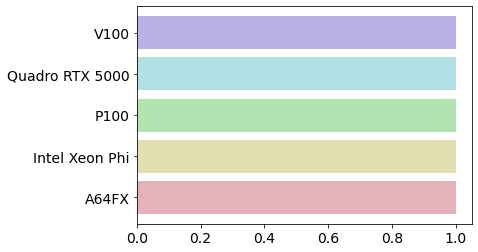

In [25]:
show_submission_colors(color_label=accelerator_short_label, color_label_range=accelerator_short_names, alpha=0.3)

### Plot parameters

In [26]:
# Plot parameters

# x-axis

x_label = 'batch size'
x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

# y-axis

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

y_label = 'time to solution [min]'
y_key = 'run_time'
y_transform = lambda t: t/60.
    
y_label = 'epoch throughput [1/min]'
y_key = 'run_epoch_throughput'
y_transform = lambda t: t/60.
    
def get_accelerator_hours(run_system_stats):
    return run_system_stats['run']['run_time']/3600*accelerator_number(run_system_stats['system'])

y_label = 'accelerator hours'
y_key = get_accelerator_hours
y_transform = None

In [27]:
if benchmark.round == 'hpc_results_v0.7':
    batch_size_to_accelerator_ratio = 1.
batch_size_to_accelerator_ratio

1.0

### Individual hyperparameter effects (off)

In [28]:
# Checking for correlations of individual hyperparameters on number of epochs to converge is possible 
# (not very helpful when everyone roughly uses the same - hence "if False")

if benchmark.name == 'cosmoflow' and False:
    x_key = lambda run_system_stats: float(run_system_stats['opt_opts']['opt_learning_rate_decay_boundary_epochs'][1])
    x_label = 'opt_learning_rate_decay_boundary_epochs[1]'
    filter_submissions = lambda submission_stat: submission_stat['division'] == 'closed'

    y_label = '# epochs to solution'
    y_key = 'run_stop_epoch'
    y_transform = None

    plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, filter_submissions=filter_submissions)

## Time to solution

In [29]:
def generate_time_to_solution_plot():
    fig, ax = plt.subplots(ncols=1,
                           figsize=(18, 12))

    # x_label = 'batch size'
    # x_key = 'global_batch_size'

    x_label = '# accelerators'
    x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

    secondary_x_label = 'batch size'
    secondary_x_legend_label = 'time to solution [min] (mean) at batch size (-- to # acc)'
    secondary_x_key = 'global_batch_size'
    secondary_x_marker = 'd'

    primary_to_secondary_x_transform = lambda a: a*batch_size_to_accelerator_ratio
    secondary_to_primary_x_transform = lambda b: b/batch_size_to_accelerator_ratio

    y_label = 'time to solution [min]'
    y_legend_label = 'time to solution [min] (dist) at # acc'
    y_key = 'run_time'
    y_transform = lambda t: t/60.

    plot_all_submissions(x_key=x_key, x_label=x_label, 
                         secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_legend_label=secondary_x_legend_label, secondary_x_marker=secondary_x_marker,
                         y_key=y_key, y_label=y_label, y_legend_label=y_legend_label, y_transform=y_transform, 
                         primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
                         sharey=True, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names, show_symbolic_legend=True,
                         level_func='x*y', level_label=(r'compute budget', r'$[accelerator \cdot h]$'), level_transform=(lambda l, s: l/60, lambda l, s: l*60), ax=ax)

    ax.yaxis.set_major_locator(plt.LogLocator(base=10.))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    
# generate_time_to_solution_plot()

In [30]:
def get_effective_epoch_samples(submissions_stats):
    submission_train_samples = np.unique([stat['train_samples'] for stat in submissions_stats.values()])
    if len(submission_train_samples) > 1:
        print("Note: different number of training samples used in different submissions! Using median of {}".format(submission_train_samples))
    submission_train_samples = np.median(submission_train_samples)


    submission_eval_samples = np.unique([stat['eval_samples'] for stat in submissions_stats.values()])
    if len(submission_eval_samples) > 1:
        print("Note: different number of evaluation samples used in different submissions! Using median of {}".format(submission_train_samples))
    submission_eval_samples = np.median(submission_eval_samples)

    mean_eff_epoch_samples = [] # handle DeepCAM separately
    submissions_runs_with_olympic_scoring = [(k, sorted(submission_stat['runs'], key=lambda run: run['run_time'])[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1]) 
                                             for k, submission_stat in submissions_stats.items()] # olympic scoring rules
    for k, runs in submissions_runs_with_olympic_scoring:
        submission_eff_epoch_samples = [runs[i]['run_avg_epoch_samples'] for i in range(len(runs))]
        if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow':
            assert np.unique(submission_eff_epoch_samples) == np.array([submission_train_samples + submission_eval_samples])
        else:
            mean_eff_epoch_samples.append(np.mean(submission_eff_epoch_samples))
    
    if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow':
        eff_epoch_samples = submission_train_samples + submission_eval_samples
    else:
        eff_epoch_samples = int(np.mean(mean_eff_epoch_samples))
    return eff_epoch_samples


In [31]:
if benchmark.round == 'hpc_results_v0.7':
    accelerators_to_epoch_throughput_ratio = 1000./1.
accelerators_to_epoch_throughput_ratio

1000.0

In [32]:
if benchmark.round == 'hpc_results_v0.7':
    batch_size_to_epochs_ratio = 256/50.
batch_size_to_epochs_ratio


5.12

## Compute time analysis: Parameter choice (batch size, # compute units), epoch- and throughput scaling, compute time

In [33]:
def generate_compute_time_analysis_plot():
    gridspec_kw = dict(width_ratios=(1,1), height_ratios=(1,10/7))
    fig, ax = plt.subplots(nrows=2, ncols=2, 
                           figsize=(32, 17), gridspec_kw=gridspec_kw)

    if benchmark.round == 'hpc_results_v0.7':
        filter_submissions = lambda s: True # e.g. s['system']['submitter'] in ['CSCS', 'Fujitsu', 'Fujitsu/RIKEN', 'LBNL', 'NCSA', 'TACC']

    #### 0,0

    y_label = 'batch size'
    y_key = 'global_batch_size'

    x_label = '# compute units'
    x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

    def submission_label_annotation_opts_parameter_choice(submission_stat):
        label = submission_stat['submission_long_label']
        if benchmark.name == 'cosmoflow':
            if label.endswith('-512'):
                y_coord = {'Cori-KNL-512': -30, 'Fugaku-512': 0, 'ABCI-512': 30}
                return dict(xytext=( -8, y_coord[label]), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)        
            elif label.endswith('-64'):
                y_coord = {'HAL-64': -30, 'Cori-GPU-64': 0, 'Frontera\n-RTX-64': 30}
                return dict(xytext=( -8, y_coord[label]), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)  
            else:
                return dict(xytext=( -8, 0), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)  
        elif benchmark.name == 'deepcam':
            if label.endswith('-1024'):
                return dict(xytext=( -8,15 if submission_stat['division'] == 'open' else -15), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)        
            else:
                return dict(xytext=( -8, 0), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)  
        else:
            return dict(xytext=( -8, 0), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)  

    submission_label_annotation_opts = submission_label_annotation_opts_parameter_choice

    plot_all_submissions_flipped(x_key=x_key, x_label=x_label,
                         y_key=y_key, y_label=y_label, 
                         level_func='y/x', level_label=(r'$\dfrac{batch\; size}{\#\; compute\; units}$', '(communication intensity:\n' + r'$\nwarrow$ low, $\searrow$ high)'), level_log_base=10., 
                         sharey=True, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names,
                         format_x_axis_as_y_axis=True, 
                         filter_submissions=filter_submissions,
                         submission_annotation_key='submission_long_label' if benchmark.name == 'deepcam' else 'submission_short_label', 
                         submission_label_annotation_opts=submission_label_annotation_opts, ax=ax[0,0])

    #### 1,0

    secondary_x_label = r'batch size ($\diamond$)' + '\n '
    secondary_x_legend_label = 'epoch throughput [1/min] (mean) at batch size (-- to # acc)'
    secondary_x_key = 'global_batch_size'
    secondary_x_marker = 'D' 

    x_label = r'# compute units ($\blacktriangle, \times$' + (')' if benchmark.name == 'cosmoflow' else r', $\mathbf{+}$)')
    x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

    primary_to_secondary_x_transform = lambda a: a*batch_size_to_accelerator_ratio
    secondary_to_primary_x_transform = lambda b: b/batch_size_to_accelerator_ratio

    # TODO: epoch time

    y_label = 'epoch throughput [1/min] ($\diamond  \cdots$)'
    y_legend_label = 'epoch throughput [1/min] (dist) at # compute units = combined throughput [samples/s]' if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow' else 'epoch throughput [1/min] (dist) at # acc'
    y_key = 'run_epoch_throughput'
    y_transform = lambda t: t*60.

    secondary_y_keys = []
    secondary_y_legend_labels = []
    secondary_y_transforms = []
    secondary_y_markers = []

    secondary_y_keys.append('run_train_throughput')
    secondary_y_transforms.append(lambda t: t) #*60.
    secondary_y_markers.append('^')
    secondary_y_legend_labels.append(r'training throughput [samples/s] (mean$\pm$std) at # acc')

    secondary_y_keys.append('run_eval_throughput')
    secondary_y_transforms.append(lambda t: t) #*60.
    secondary_y_markers.append('x')
    secondary_y_legend_labels.append(r'evaluation throughput [samples/s] (mean$\pm$std) at # acc')

    if not(benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow'):
        secondary_y_keys.append('run_avg_epoch_sample_throughput')
        secondary_y_transforms.append(lambda t: t) #*60.
        secondary_y_markers.append('P')
        secondary_y_legend_labels.append(r'average throughput [samples/s] (mean$\pm$std) at # acc')

    # if benchmark.round == 'hpc_results_v0.7':
    #     secondary_y_keys.append('run_staging_throughput')
    #     secondary_y_transforms.append(lambda t: t) #*60.
    #     secondary_y_markers.append('s')
    #     secondary_y_legend_labels.append(r'staging throughput [samples/s] (mean$\pm$std) at # acc')

    secondary_y_axis_label = 'system sample throughput [samples/s]\n' + r'($\blacktriangle$ training, $\times$ evaluation, ' + (r'$\diamond \cdots$' if benchmark.name == 'cosmoflow' else r'$\mathbf{+} $') + ' combined)'

    eff_epoch_samples = get_effective_epoch_samples(submissions_stats)
    primary_to_secondary_y_transform = lambda et: et*float(eff_epoch_samples)/60. 
    secondary_to_primary_y_transform = lambda st: st/float(eff_epoch_samples)*60.

    # Epoch throughput w/o initial phase, i.e. staging overhead not shown

    level_func='y/x' 
    level_label=('per compute unit\nsample throughput\n' + r'$[samples/s]$', r'($\nwarrow$ high, $\searrow$ low)')
    level_transform=(primary_to_secondary_y_transform, secondary_to_primary_y_transform)

    plot_all_submissions(y_key=y_key, y_label=y_label, y_transform=y_transform, y_legend_label=y_legend_label, 
                         secondary_y_keys=secondary_y_keys, secondary_y_axis_label=secondary_y_axis_label, secondary_y_legend_labels=secondary_y_legend_labels, secondary_y_transforms=secondary_y_transforms, secondary_y_markers=secondary_y_markers,
                         primary_to_secondary_y_transform=primary_to_secondary_y_transform, secondary_to_primary_y_transform=secondary_to_primary_y_transform,
                         x_key=x_key, x_label=x_label,
                         secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_legend_label=secondary_x_legend_label, secondary_x_marker=secondary_x_marker, secondary_x_ticks_same_as_primary=True,
                         primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform, 
                         sharey=False, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names, legend_side='left', show_symbolic_legend=True,
                         level_func=level_func, level_label=level_label, level_transform=level_transform, level_fine_grid=2, filter_submissions=filter_submissions, 
                         submission_annotation_key='submission_long_label' if benchmark.name == 'deepcam' else 'submission_short_label', 
                         color_legend_label=color_legend_label, ax=ax[1,0])        

    ### 0,1

    y_label = 'batch size'
    y_key = 'global_batch_size'

    x_label = '# epochs to solution'
    x_key = 'run_stop_epoch'
    x_transform = None

    def submission_label_annotation_opts_epoch_scaling(submission_stat):
        label = submission_stat['submission_long_label']
        if benchmark.name == 'cosmoflow':
            if label == 'Piz-Daint-256':
                return dict(xytext=( 10, -2),
                            textcoords="offset points",
                            ha='center', va='top', rotation=90,      
                            alpha=1., fontsize=12)        
            elif label in ['HAL-64']:
                return dict(xytext=( 13, -2),
                            textcoords="offset points",
                            ha='center', va='top', rotation=90,      
                            alpha=1., fontsize=12)        
            elif label in ['Fugaku-512']:
                return dict(xytext=( -15, -2),
                            textcoords="offset points",
                            ha='center', va='top', rotation=90,      
                            alpha=1., fontsize=12)        
            elif label in ['Fugaku-8192']:
                return dict(xytext=( 5, -2),
                            textcoords="offset points",
                            ha='center', va='top', rotation=90,      
                            alpha=1., fontsize=12)        
            elif 'Frontera' in label:
                return dict(xytext=( -5, -2),
                            textcoords="offset points",
                            ha='center', va='top', rotation=90,      
                            alpha=1., fontsize=12)        
            else:
                return dict(xytext=( 0, -2),
                            textcoords="offset points",
                            ha='center', va='top', rotation=90,      
                            alpha=1., fontsize=12)
        elif benchmark.name == 'deepcam':
            if label.endswith('-1024'):
                return dict(xytext=( -3 if submission_stat['division'] == 'open' else 3, -2.5),
                            textcoords="offset points",
                            ha='center', va='top', rotation=90,      
                            alpha=1., fontsize=12)        
            else:
                return dict(xytext=( 0, -2.5),
                            textcoords="offset points",
                            ha='center', va='top', rotation=90,      
                            alpha=1., fontsize=12)
        else:
            return dict(xytext=( 0, -2.5),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)

    submission_label_annotation_opts = submission_label_annotation_opts_epoch_scaling
    plot_all_submissions_flipped(y_key=y_key, y_label=y_label, 
                         x_key=x_key, x_label=x_label, x_transform=x_transform, 
                         level_func='x/y', level_label=('# train steps to solution', r'($\nwarrow$ low, $\searrow$ high)'), 
                         level_transform=(lambda l, s: l*s['train_samples'], lambda l, s: l/s['train_samples']), level_fine_grid=3,
                         sharey=True, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names, filter_submissions=filter_submissions, 
                         submission_annotation_key='submission_epochs_label',
                         submission_label_annotation_opts=submission_label_annotation_opts, ax=ax[0,1])

    ax[0,1].xaxis.set_major_locator(plt.AutoLocator())
    ax[0,1].xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax[0,1].yaxis.set_major_locator(plt.LogLocator(base=2.))
    ax[0,1].yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

    ### 1,1

    x_label = '# epochs to solution'
    x_key = 'run_stop_epoch'
    x_transform = None

    y_label = 'epoch throughput [1/min]'
    y_key = 'run_epoch_throughput'
    y_transform = lambda t: t*60.

    level_func='x/y' 
    level_label=('compute time\nto solution' + r' $[min]$', r'($\nwarrow$ low, $\searrow$ high)') 

    submission_label_annotation_opts = dict(
                        xytext=(0, 0),
                        textcoords="offset points",
                        ha='right', va='top',  rotation=14.75,
                        alpha=1., fontsize=12)

    plot_all_submissions_scatter_vector(x_key=x_key, x_label=x_label, x_transform=x_transform, 
                                        y_key=y_key, y_label=y_label, y_transform=y_transform,
                                        xy_mean_marker='o',
                                        sharey=True, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names,
                                        level_func=level_func, level_label=level_label, level_fine_grid=2,
                                        filter_submissions=filter_submissions,
                                        submission_annotation_key='submission_long_label',
                                        submission_label_annotation_opts=submission_label_annotation_opts,
                                        ax=ax[1,1])

    ax[1,1].xaxis.set_major_locator(plt.AutoLocator())
    ax[1,1].xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

    ax[0,0].set_xlim(ax[1,0].get_xlim())
    ax[0,0].set_ylim(ax[0,1].get_ylim())

    ax[1,1].set_xlim(ax[0,1].get_xlim())
    ax[1,1].set_ylim(ax[1,0].get_ylim())

    ax[0,0].legend().set_visible(False)
    ax[0,1].legend().set_visible(False)
    ax[1,0].legend().set_visible(False)
    ax[1,1].legend().set_visible(False)

    fig.tight_layout()
# generate_compute_time_analysis_plot()

# Tabular analysis

In [34]:
def olympic_scoring_of_runs(runs):
    return sorted(runs, key=lambda run: run['run_time'])[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules (discards the best and worst run (if invalid should be skipped at parsing))

from copy import deepcopy
submissions_stats_olympic = deepcopy(submissions_stats)
for k in submissions_stats_olympic:
    submissions_stats_olympic[k]['runs'] = olympic_scoring_of_runs(submissions_stats_olympic[k]['runs']) # olympic scoring rules

In [35]:
submissions_stats_df = pd.DataFrame.from_dict(submissions_stats_olympic, orient='index').sort_values(['division'])

In [36]:
pd.set_option('display.max_columns', None)
def visualize_submissions_by_opt(submissions_stats_df_opt_vis, sort_keys=['global_batch_size']):
    if benchmark.round == 'training_results_v0.7':
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'closed') & (submissions_stats_df_opt_vis['opt_name'] == 'sgd')].drop(columns=[c for c in submissions_stats_df_opt_vis.columns if c.startswith('lars_')]).sort_values(sort_keys))
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'closed') & (submissions_stats_df_opt_vis['opt_name'] == 'lars')].drop(columns=[c for c in submissions_stats_df_opt_vis.columns if c.startswith('sgd_') or c == 'model_bn_span' or c == 'opt_learning_rate_warmup_epochs']).sort_values(sort_keys))
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'open')].sort_values(sort_keys))
    else:
        display(submissions_stats_df_opt_vis.sort_values(['division'] + sort_keys))

### Runtime statistics

In [37]:
def throughput_aware_mean(run_metric):
    if not run_metric.name.endswith('throughput'):
        return run_metric.mean()
    else:
        return 1./(1./run_metric).mean()

def throughput_aware_std(run_metric):
    if not run_metric.name.endswith('throughput'):
        return run_metric.std()
    else:
        mean = throughput_aware_mean(run_metric)
        return 1./(1./mean - (1./run_metric).std()) - mean

submissions_stats_df_run_mean = submissions_stats_df['runs'].apply(lambda expt: pd.DataFrame.from_dict(expt).apply(throughput_aware_mean)).add_suffix('.mean')
submissions_stats_df_run_mean.index = submissions_stats_df.index
submissions_stats_df_run_std = submissions_stats_df['runs'].apply(lambda expt: pd.DataFrame.from_dict(expt).apply(throughput_aware_std)).add_suffix('.std')
submissions_stats_df_run_std.index = submissions_stats_df.index
submissions_stats_df_run = submissions_stats_df_run_mean.join(submissions_stats_df_run_std)

for c in submissions_stats_df_run.columns: # transform units from seconds to minutes
    if 'throughput' in c:
        submissions_stats_df_run[c] *= 60.
    elif 'time' in c:
        submissions_stats_df_run[c] /= 60.

submissions_stats_df_run['staging_time/run_time'] = submissions_stats_df_run.apply(lambda row: row['run_staging_time.mean']/row['run_time.mean'], axis=1)
submissions_stats_df_run['train_time/run_time']   = submissions_stats_df_run.apply(lambda row: row['run_train_time.mean']/row['run_time.mean'], axis=1)
submissions_stats_df_run['eval_time/run_time']    = submissions_stats_df_run.apply(lambda row: row['run_eval_time.mean']/row['run_time.mean'], axis=1)

submissions_stats_df_run = submissions_stats_df_run[sorted(submissions_stats_df_run.columns)]
submissions_stats_df_run.index = submissions_stats_df.index
submissions_stats_df_run

submissions_stats_df_run_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'opt_opts', 'system']).join(submissions_stats_df_run).set_index('submission_label').sort_values(['division', 'global_batch_size'])
display(submissions_stats_df_run_vis)

,global_batch_size,opt_name,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,eval_time/run_time,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_samples.mean,run_avg_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,run_epoch_time.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_time.mean,run_eval_time.std,run_num_evals.mean,run_num_evals.std,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std,run_train_time.mean,run_train_time.std,staging_time/run_time,train_time/run_time
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LBNL-1/corigpu_n64_pt1.6.0,128,LAMB,121216,15158,closed,Cori-GPU-64,Cori\n-GPU-64,0.362732,13636.646533,307.016017,189932.0,874.685658,0.071793,0.001919,13.928849,0.362650,13605.274039,704.124769,50.524406,3.044168,45.333333,0.577350,NaN,NaN,NaN,NaN,10.000000,0.000000,139.288611,3.626479,13655.973840,496.046978,88.764083,3.111298,NaN,0.637267
Fujitsu-1/abci_1024xV100_pytorch_closed,2048,LAMB,121266,15158,closed,ABCI-1024,ABCI-1024,0.040034,328452.837177,954.164474,130108.0,0.000000,2.524463,0.007334,0.396124,0.001147,452842.370981,427.222282,0.468622,0.000442,14.000000,0.000000,62072.354483,180.453773,2.197822,0.006371,24.000000,0.000000,11.705717,0.021555,322003.905651,993.958276,9.038350,0.027814,0.187756,0.772131
Fujitsu-2/abci_1024xV100_fjpytorch_open,2048,LAMB,121266,15158,open,ABCI-1024,ABCI\n-1024,0.013057,341240.183868,8540.870875,122953.0,639.126748,2.775585,0.056186,0.360284,0.007149,281674.493324,53363.772466,0.136906,0.033568,2.666667,1.154701,69521.318153,2846.825395,1.962333,0.077194,23.666667,1.154701,10.485394,0.228172,342041.745864,8021.315726,8.385078,0.246814,0.187149,0.799691


In [38]:
# if benchmark.round == 'hpc_results_v0.7':
#     if benchmark.name == 'cosmoflow':
#
#         # Run-to-run variation
#         print((submissions_stats_df_run_vis[submissions_stats_df_run_vis['global_batch_size'] <= 1024]['run_time.std']/submissions_stats_df_run_vis[submissions_stats_df_run_vis['global_batch_size'] <= 1024]['run_time.mean']).mean()) #.to_latex(float_format="{:0.2f}".format)) #, 'staging_time/run_time', 'train_time/run_time', 'eval_time/run_time']] 
#
#         # Throughput scaling
#         submissions_stats_df_run_vis.loc['CSCS-1/daint_gpu_n256_tf2.2.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/2./submissions_stats_df_run_vis.loc['CSCS-2/daint_gpu_n128_tf2.2.0',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['LBNL-2/coriknl_n1024_tf1.15.2',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/2./submissions_stats_df_run_vis.loc['LBNL-1/coriknl_n512_tf1.15.2',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['Fujitsu-1/abci_2048xV100_tensorflow_open',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/4./submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/16./submissions_stats_df_run_vis.loc['RIKEN-1/fugaku_512xA64FX_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['Fujitsu-2/fugaku_16384xA64FX_tensorflow_open',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/8./4./submissions_stats_df_run_vis.loc['RIKEN-1/fugaku_512xA64FX_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]*8./submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]*8./submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/8./submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/8./submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
#         submissions_stats_df_run_vis.loc['LBNL-1/corigpu_n64_pt1.6.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]*16./submissions_stats_df_run_vis.loc['Fujitsu-1/abci_1024xV100_pytorch_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]


### Data staging analysis: Relative time spent in staging, evaluation and training and T_staging/T_epoch-ratio

In [39]:
if benchmark.round == 'hpc_results_v0.7':
    if benchmark.name == 'cosmoflow':
        submissions_stats_df_run_vis_cosmoflow = submissions_stats_df_run_vis
        submissions_stats_df_run_vis_cosmoflow = submissions_stats_df_run_vis_cosmoflow.reindex([
            'CSCS-2/daint_gpu_n128_tf2.2.0',
            'CSCS-1/daint_gpu_n256_tf2.2.0', 
            'Fujitsu-4/abci_512xV100_tensorflow_closed',
            'Fujitsu-1/abci_2048xV100_tensorflow_open',
            'RIKEN-1/fugaku_512xA64FX_tensorflow_closed',
            'Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed',
            'Fujitsu-2/fugaku_16384xA64FX_tensorflow_open',
            'LBNL-3/corigpu_n64_tf1.15.0',
            'LBNL-1/coriknl_n512_tf1.15.2',
            'LBNL-2/coriknl_n1024_tf1.15.2',
            'NCSA-1/halv100_n16_tf1.15.0', 
            'TACC-1/frontera_rtx_n16_tf1.15.2_lbs1'])
        submissions_stats_df_run_vis_all = submissions_stats_df_run_vis_cosmoflow
    else:
        submissions_stats_df_run_vis_deepcam = submissions_stats_df_run_vis.reindex([
            'LBNL-1/corigpu_n64_pt1.6.0', 
            'Fujitsu-1/abci_1024xV100_pytorch_closed',
            'Fujitsu-2/abci_1024xV100_fjpytorch_open'])
        submissions_stats_df_run_vis_all = submissions_stats_df_run_vis_deepcam
        if 'submissions_stats_df_run_vis_cosmoflow' in locals():
            submissions_stats_df_run_vis_all = pd.concat([submissions_stats_df_run_vis_cosmoflow, submissions_stats_df_run_vis_deepcam])
    display(submissions_stats_df_run_vis_all[['staging_time/run_time', 'eval_time/run_time', 'train_time/run_time']])

    def generate_relative_staging_eval_training_times_plot():
        def create_relative_time_plot(df, ax, split=None):
            ind = np.arange(len(df.index), 0, -1) + 0.0
            if split is not None:
                ind[:split] += .66

            ax.barh(ind, df['eval_time/run_time'] + df['train_time/run_time'] + df['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='train')
            ax.barh(ind, df['eval_time/run_time'] + df['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='eval')
            ax.barh(ind, df['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='staging')

            ax.set_yticks(ind)
            ax.set_yticklabels(df.apply(lambda row: (r'$\bigstar$' if row['division'] == 'open' else '') + row['submission_long_label'].replace('\n',''), axis=1))
            ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
            ax.set_xticks(np.linspace(0,1.,41), minor=True)
            ax.set_xlim([0,1])
            ax.grid(True, which='major', axis='x', alpha=1.)
            ax.grid(True, which='minor', axis='x', alpha=0.5)
            ax.set_ylim(0.4,df.shape[0] + 0.8 + (0. if split is None else 0.5))

        fig, ax = plt.subplots(figsize=(10,4.5))
        if 'submissions_stats_df_run_vis_cosmoflow' in locals() and 'submissions_stats_df_run_vis_deepcam' in locals():
            create_relative_time_plot(submissions_stats_df_run_vis_all, ax, split=int(-submissions_stats_df_run_vis_deepcam.shape[0]))
        else:
            create_relative_time_plot(submissions_stats_df_run_vis_all, ax, split=None)        
        fig.tight_layout()
#     generate_relative_staging_eval_training_times_plot()

,staging_time/run_time,eval_time/run_time,train_time/run_time
submission_label,,,
LBNL-1/corigpu_n64_pt1.6.0,NaN,0.362732,0.637267
Fujitsu-1/abci_1024xV100_pytorch_closed,0.187756,0.040034,0.772131
Fujitsu-2/abci_1024xV100_fjpytorch_open,0.187149,0.013057,0.799691


In [40]:
# Staging to epoch time ratio
if benchmark.round == 'hpc_results_v0.7':  # show staging time and relation to compute
    submissions_stats_df_run_vis_times = submissions_stats_df_run_vis[ ['run_time.mean', 'run_time.std'] + 
                                                                       ['run_staging_time.mean', 'run_staging_time.std'] + 
                                                                       ['run_epoch_time.mean', 'run_epoch_time.std'] ].applymap(lambda s: s*60.)
    submissions_stats_df_run_vis_times['run_staging_epoch_time_ratio'] = \
                                                    submissions_stats_df_run_vis.apply(lambda s: s['run_staging_time.mean']/s['run_epoch_time.mean'], axis=1)
submissions_stats_df_run_vis_times.dropna()

,run_time.mean,run_time.std,run_staging_time.mean,run_staging_time.std,run_epoch_time.mean,run_epoch_time.std,run_staging_epoch_time_ratio
submission_label,,,,,,,
Fujitsu-1/abci_1024xV100_pytorch_closed,702.343000,1.293315,131.869333,0.382253,23.767431,0.068845,5.548321
Fujitsu-2/abci_1024xV100_fjpytorch_open,629.123667,13.690344,117.740000,4.631668,21.617065,0.428912,5.446623


### Comparing systems with submissions to both benchmarks

In [41]:
if benchmark.round == 'hpc_results_v0.7':
    if benchmark.name == 'cosmoflow':
        submissions_to_show = ['LBNL-3/corigpu_n64_tf1.15.0',
                               'Fujitsu-4/abci_512xV100_tensorflow_closed',
                               'Fujitsu-1/abci_2048xV100_tensorflow_open']
    else:
        submissions_to_show = ['LBNL-1/corigpu_n64_pt1.6.0', 
                               'Fujitsu-1/abci_1024xV100_pytorch_closed',
                               'Fujitsu-2/abci_1024xV100_fjpytorch_open']

    display(submissions_stats_df_run_vis.loc[submissions_to_show,:])

,global_batch_size,opt_name,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,eval_time/run_time,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_samples.mean,run_avg_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,run_epoch_time.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_time.mean,run_eval_time.std,run_num_evals.mean,run_num_evals.std,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std,run_train_time.mean,run_train_time.std,staging_time/run_time,train_time/run_time
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LBNL-1/corigpu_n64_pt1.6.0,128,LAMB,121216,15158,closed,Cori-GPU-64,Cori\n-GPU-64,0.362732,13636.646533,307.016017,189932.0,874.685658,0.071793,0.001919,13.928849,0.362650,13605.274039,704.124769,50.524406,3.044168,45.333333,0.577350,NaN,NaN,NaN,NaN,10.000000,0.000000,139.288611,3.626479,13655.973840,496.046978,88.764083,3.111298,NaN,0.637267
Fujitsu-1/abci_1024xV100_pytorch_closed,2048,LAMB,121266,15158,closed,ABCI-1024,ABCI-1024,0.040034,328452.837177,954.164474,130108.0,0.000000,2.524463,0.007334,0.396124,0.001147,452842.370981,427.222282,0.468622,0.000442,14.000000,0.000000,62072.354483,180.453773,2.197822,0.006371,24.000000,0.000000,11.705717,0.021555,322003.905651,993.958276,9.038350,0.027814,0.187756,0.772131
Fujitsu-2/abci_1024xV100_fjpytorch_open,2048,LAMB,121266,15158,open,ABCI-1024,ABCI\n-1024,0.013057,341240.183868,8540.870875,122953.0,639.126748,2.775585,0.056186,0.360284,0.007149,281674.493324,53363.772466,0.136906,0.033568,2.666667,1.154701,69521.318153,2846.825395,1.962333,0.077194,23.666667,1.154701,10.485394,0.228172,342041.745864,8021.315726,8.385078,0.246814,0.187149,0.799691


### Optimizer convergence

In [42]:
submissions_stats_df_opt = pd.json_normalize(submissions_stats_df['opt_opts'])
submissions_stats_df_opt.index = submissions_stats_df.index
submissions_stats_df_opt = submissions_stats_df[['global_batch_size', 'opt_name']].join(submissions_stats_df_opt) #.add_prefix('opt.')

submissions_stats_df_opt_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'global_batch_size', 'opt_name', 'opt_opts', 'system']).join(submissions_stats_df_run[['run_stop_epoch.mean', 'run_stop_epoch.std']]).join(submissions_stats_df_opt).set_index('submission_label')
visualize_submissions_by_opt(submissions_stats_df_opt_vis, sort_keys=['global_batch_size'])

,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,run_stop_epoch.mean,run_stop_epoch.std,global_batch_size,opt_name,opt_epsilon,opt_base_learning_rate,opt_learning_rate_warmup_steps,opt_learning_rate_warmup_factor,opt_weight_decay
submission_label,,,,,,,,,,,,,,
LBNL-1/corigpu_n64_pt1.6.0,121216,15158,closed,Cori-GPU-64,Cori\n-GPU-64,10.000000,0.000000,128,LAMB,1.000000e-08,0.0010,0.0,1.0,0.01
Fujitsu-1/abci_1024xV100_pytorch_closed,121266,15158,closed,ABCI-1024,ABCI-1024,24.000000,0.000000,2048,LAMB,1.000000e-08,0.0055,400.0,1.0,0.01
Fujitsu-2/abci_1024xV100_fjpytorch_open,121266,15158,open,ABCI-1024,ABCI\n-1024,23.666667,1.154701,2048,LAMB,NaN,NaN,NaN,NaN,NaN


### System throughput performance

In [43]:
pd.set_option("display.max_columns", 0)
submissions_stats_df_system = pd.json_normalize(submissions_stats_df['system']).add_prefix('system.')
submissions_stats_df_system['system.number_of_compute_units'] = \
    submissions_stats_df_system.apply(
    lambda submission_stat:  int(submission_stat['system.number_of_nodes'])*
                             int(submission_stat['system.accelerators_per_node'] 
                             if int(submission_stat['system.accelerators_per_node']) > 0 
                             else submission_stat['system.host_processors_per_node']), axis=1).rename_axis('system.number_of_compute_units')
submissions_stats_df_system.index = submissions_stats_df.index

throughput_keys = [['run_epoch_throughput.mean','run_epoch_throughput.std'],
                   ['run_avg_epoch_sample_throughput.mean', 'run_avg_epoch_sample_throughput.std'],
                   ['run_eval_throughput.mean', 'run_eval_throughput.std'],
                   ['run_train_throughput.mean', 'run_train_throughput.std']]
submissions_stats_df_system_run_vis_list = []

for throughput_key in throughput_keys:
    submissions_stats_df_system_run_vis = \
        submissions_stats_df_run[throughput_key].join(submissions_stats_df_system)
    submissions_stats_df_system_run_vis = \
        submissions_stats_df_run[throughput_key].join(
            submissions_stats_df_system_run_vis.apply(lambda submissions_stat: submissions_stat[throughput_key[0]:throughput_key[1]]/
                                                                                                    ( float(submissions_stat['system.number_of_nodes'])*
                                                                                                      float(submissions_stat['system.accelerators_per_node'] 
                                                                                                            if int(submissions_stat['system.accelerators_per_node']) > 0 
                                                                                                            else submissions_stat['system.host_processors_per_node']) )/(1. if throughput_key[0].startswith('run_epoch') else 60.), axis=1).rename(columns=lambda s: '_per_accelerator.'.join(s.split('.'))))
    submissions_stats_df_system_run_vis_list.append(submissions_stats_df_system_run_vis)
submissions_stats_df_system_run_vis = pd.concat(submissions_stats_df_system_run_vis_list, axis=1)
submissions_stats_df_system_run_vis['run_compute_budget'] = submissions_stats_df_system['system.number_of_compute_units']*submissions_stats_df_run['run_time.mean'].apply(lambda t: t/60.)

submissions_stats_df_system_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'opt_opts', 'system']).join(submissions_stats_df_system_run_vis).join(submissions_stats_df_system).set_index('submission_label')
# visualize_submissions_by_opt(submissions_stats_df_system_vis, sort_keys=['run_epoch_throughput_per_accelerator.mean'])
submissions_stats_df_system_vis.sort_values(['division', 'global_batch_size']) # 'run_epoch_throughput_per_accelerator.mean'])

,global_batch_size,opt_name,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_throughput_per_accelerator.mean,run_epoch_throughput_per_accelerator.std,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_sample_throughput_per_accelerator.mean,run_avg_epoch_sample_throughput_per_accelerator.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_throughput_per_accelerator.mean,run_eval_throughput_per_accelerator.std,run_train_throughput.mean,run_train_throughput.std,run_train_throughput_per_accelerator.mean,run_train_throughput_per_accelerator.std,run_compute_budget,system.submitter,system.division,system.system_type,system.status,system.system_name,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.host_processor_core_count,system.host_processor_vcpu_count,system.host_processor_frequency,system.host_processor_caches,system.host_processor_interconnect,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology,system.host_memory_configuration,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_host_interconnect,system.accelerator_frequency,system.accelerator_on-chip_memories,system.accelerator_memory_configuration,system.accelerator_memory_capacity,system.accelerator_interconnect,system.accelerator_interconnect_topology,system.cooling,system.hw_notes,system.framework,system.other_software_stack,system.operating_system,system.sw_notes,system.other_software_stack.CUDA,system.other_software_stack.NCCL,system.other_software_stack.h5py,system.number_of_compute_units
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LBNL-1/corigpu_n64_pt1.6.0,128,LAMB,121216,15158,closed,Cori-GPU-64,Cori\n-GPU-64,0.071793,0.001919,0.001122,0.000030,13636.646533,307.016017,3.551210,0.079952,13605.274039,704.124769,3.543040,0.183366,13655.973840,496.046978,3.556243,0.129179,148.574519,LBNL,closed,NaN,onprem,corigpu_n64_pt1.6.0,8,2,Intel Xeon Gold 6148,20,40,2.4 GHz,,,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,,,8,NVIDIA V100,PCIe 3.0,1245 MHz,,,8 GB,NVLink,hybrid cube-mesh,,https://docs-dev.nersc.gov/cgpu/hardware/,PyTorch 1.6.0,NaN,openSUSE 15.0,,10.2.89,2.5.6,2.10.0,64
Fujitsu-1/abci_1024xV100_pytorch_closed,2048,LAMB,121266,15158,closed,ABCI-1024,ABCI-1024,2.524463,0.007334,0.002465,0.000007,328452.837177,954.164474,5.345912,0.015530,452842.370981,427.222282,7.370481,0.006953,322003.905651,993.958276,5.240949,0.016178,199.777564,Fujitsu,closed,datacenter,available,ABCI PRIMERGY CX2570 M4,256,2,Intel Xeon Gold 6148,40,80,2400MHz,"L1: 32KB I + 32KB D per core, L2: 1MB I+D per ...",3x 10.4GT/s UPI,384GB,SSD+NVMe,1600GB,N/A,N/A,12x32GB,4,NVIDIA Tesla V100,PCIe 3.0 x16,1530MHz,"L1: 80x 128KB, L2: 6MB per chip",HBM2,16GB,6x 25GT/s NVLink,Direct,Water-cooled,none,PyTorch 1.6.0,"cuda 10.2.89, cudnn, 7.6.5, cublas 10.2.2.89, ...",CentOS 7.5.1804,none,NaN,NaN,NaN,1024
Fujitsu-2/abci_1024xV100_fjpytorch_open,2048,LAMB,121266,15158,open,ABCI-1024,ABCI\n-1024,2.775585,0.056186,0.002711,0.000055,341240.183868,8540.870875,5.554039,0.139012,281674.493324,53363.772466,4.584546,0.868551,342041.745864,8021.315726,5.567086,0.130555,178.950732,Fujitsu,open,datacenter,available,ABCI PRIMERGY CX2570 M4,256,2,Intel Xeon Gold 6148,40,80,2400MHz,"L1: 32KB I + 32KB D per core, L2: 1MB I+D per ...",3x 10.4GT/s UPI,384GB,SSD+NVMe,1600GB,N/A,N/A,12x32GB,4,NVIDIA Tesla V100,PCIe 3.0 x16,1530MHz,"L1: 80x 128KB, L2: 6MB per chip",HBM2,16GB,6x 25GT/s NVLink,Direct,Water-cooled,none,PyTorch 1.6.0,"cuda 10.2.89, cudnn, 7.6.5, cublas 10.2.2.89, ...",CentOS 7.5.1804,none,NaN,NaN,NaN,1024


### Systems table

In [44]:
# System configuration
display(submissions_stats_df_system_vis[[ 'system.number_of_nodes', 'system.host_processors_per_node', 'system.host_processor_model_name', 'system.accelerators_per_node', 'system.accelerator_model_name', 'system.accelerator_memory_capacity', 'system.host_memory_capacity',  'system.host_storage_type', 'system.host_storage_capacity', 'system.host_networking', 'system.host_networking_topology']])

,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_memory_capacity,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology
submission_label,,,,,,,,,,,
Fujitsu-1/abci_1024xV100_pytorch_closed,256,2,Intel Xeon Gold 6148,4,NVIDIA Tesla V100,16GB,384GB,SSD+NVMe,1600GB,N/A,N/A
LBNL-1/corigpu_n64_pt1.6.0,8,2,Intel Xeon Gold 6148,8,NVIDIA V100,8 GB,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,
Fujitsu-2/abci_1024xV100_fjpytorch_open,256,2,Intel Xeon Gold 6148,4,NVIDIA Tesla V100,16GB,384GB,SSD+NVMe,1600GB,N/A,N/A


### Compute budget (hours x # compute units)

In [45]:
# Compute budget
submissions_stats_df_system_vis[['run_compute_budget']]

,run_compute_budget
submission_label,
Fujitsu-1/abci_1024xV100_pytorch_closed,199.777564
LBNL-1/corigpu_n64_pt1.6.0,148.574519
Fujitsu-2/abci_1024xV100_fjpytorch_open,178.950732


In [46]:
# Cross-benchmark compute budget comparison
if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow':
    submissions_stats_df_system_vis.loc[['LBNL-3/corigpu_n64_tf1.15.0','Fujitsu-4/abci_512xV100_tensorflow_closed','Fujitsu-1/abci_2048xV100_tensorflow_open'],'run_compute_budget']/np.array([148.575, 199.778, 178.951])

### Explaining run-to-run variation in terms of # epochs vs. system throughput with logarithmic PCA

In [47]:
from sklearn.decomposition import PCA

log_pca = dict({k:[] for k in ['submission_label',
                               'explained_variance_1', 'explained_variance_ratio_1','epochs_component_1','system_component_1',
                               'explained_variance_2', 'explained_variance_ratio_2','epochs_component_2','system_component_2',
                               'epochs_system_correlation']})
for k, submission_stat in submissions_stats.items():
    log_pca['submission_label'].append(submission_stat['submission_label'])
    pca = PCA(n_components=2)
    log_num_epochs_log_epoch_times = pd.DataFrame(sorted(submissions_stats[k]['runs'], key=lambda run: run['run_time'])[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1])[['run_stop_epoch', 'run_epoch_time']].applymap(np.log10)
    pca.fit(log_num_epochs_log_epoch_times)
    for i in range(2):
        log_pca[f'explained_variance_{i+1}'].append(pca.explained_variance_[i])
        log_pca[f'explained_variance_ratio_{i+1}'].append(pca.explained_variance_ratio_[i])
        log_pca[f'epochs_component_{i+1}'].append(pca.components_[i][0])
        log_pca[f'system_component_{i+1}'].append(pca.components_[i][1])
    log_pca[f'epochs_system_correlation'].append(log_num_epochs_log_epoch_times.corr().iloc[0,1])
run_to_run_variation_log_pca_df = pd.DataFrame.from_dict(log_pca).set_index('submission_label')
run_to_run_variation_log_pca_df

,explained_variance_1,explained_variance_ratio_1,epochs_component_1,system_component_1,explained_variance_2,explained_variance_ratio_2,epochs_component_2,system_component_2,epochs_system_correlation
submission_label,,,,,,,,,
Fujitsu-1/abci_1024xV100_pytorch_closed,0.000002,1.000000,1.558375e-26,1.000000,7.395571e-32,4.676760e-26,1.000000,-1.558375e-26,7.208606e-14
Fujitsu-2/abci_1024xV100_fjpytorch_open,0.000495,0.967857,9.376351e-01,-0.347621,1.643679e-05,3.214297e-02,-0.347621,-9.376351e-01,-8.656630e-01
LBNL-1/corigpu_n64_pt1.6.0,0.000128,1.000000,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,NaN


In [48]:
def generate_run_to_run_variation_log_pca_plot():
    # Log-PCA plot
    fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
    colors = create_submission_colors(color_label=accelerator_short_label, color_label_range=accelerator_short_names)    
    run_to_run_variation_log_pca_acc_df = \
        pd.concat([run_to_run_variation_log_pca_df, 
                   submissions_stats_df_system_vis[['system.host_processors_per_node', 'system.host_processor_model_name', 'system.accelerators_per_node', 'system.accelerator_model_name']].apply(
                       lambda r: accelerator_short_label(r['system.accelerator_model_name'] if int(r['system.accelerators_per_node']) > 0 else r['system.host_processor_model_name']), axis=1).rename('accelerator_short_label')], axis=1)

    ax_box_xlim =(np.inf, -np.inf)
    ax_box_ylim =(np.inf, -np.inf)

    for s_label, s_log_pca_acc in run_to_run_variation_log_pca_acc_df.iterrows():

        half_axis_log = []
        for i in range(1,3):
            half_axis_log.append(np.array(
                     [np.sqrt(s_log_pca_acc[f'explained_variance_{i}'])*s_log_pca_acc[f'epochs_component_{i}']*np.sign(s_log_pca_acc[f'epochs_component_{i}']),
                      np.sqrt(s_log_pca_acc[f'explained_variance_{i}'])*s_log_pca_acc[f'system_component_{i}']*np.sign(s_log_pca_acc[f'epochs_component_{i}'])]))

        t = np.linspace(0,2.*np.pi, 1000)
        circle_coord = [10**(half_axis_log[0][0]*np.cos(t)+half_axis_log[1][0]*np.sin(t)), 
                        10**(half_axis_log[0][1]*np.cos(t)+half_axis_log[1][1]*np.sin(t))]
        ax.loglog(circle_coord[0], circle_coord[1],  color=colors[s_log_pca_acc['accelerator_short_label']], alpha=0.4)
        ax_box_xlim = (min(np.min(circle_coord[0]), ax_box_xlim[0]), max(np.max(circle_coord[0]), ax_box_ylim[0]))
        ax_box_ylim = (min(np.min(circle_coord[1]), ax_box_ylim[1]), max(np.max(circle_coord[1]), ax_box_ylim[1]))

        for i in range(2):
            ax.loglog(10**(half_axis_log[i][0]*np.array([1.,-1.])),
                      10**(half_axis_log[i][1]*np.array([1.,-1.])),
                      '--' if i == 0 else ':', alpha=0.4, color=colors[s_log_pca_acc['accelerator_short_label']])

        annotation_pos = np.array([circle_coord[0][0],circle_coord[1][0]])
        submission_long_label = submissions_stats_df.set_index('submission_label').loc[s_label]['submission_long_label']
        submission_label_annotation_opts = dict(
            xytext=(5, 0)  if 'Fugaku' not in submission_long_label else (-5, 0),
            textcoords="offset points", 
            ha='left' if 'Fugaku' not in submission_long_label else 'right', va='center', 
            rotation=0,
            alpha=1., fontsize=12)
        annotation_text = (r'$\bigstar$' if submissions_stats_df.set_index('submission_label').loc[s_label]['division'] == 'open' else '') + \
                          submission_long_label
        ax.annotate(annotation_text,
            xy=annotation_pos if 'Fugaku' not in submission_long_label else 1./annotation_pos, 
            color=colors[s_log_pca_acc['accelerator_short_label']],
            **submission_label_annotation_opts)

    ax.annotate('compute time to solution\n' + r'($\nwarrow$ low, $\searrow$ high, ' + '\n' + r' const. along $\nearrow$)',
                xy=(ax_box_xlim[0], ax_box_ylim[1]),
                xytext=(15,-50),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize='small',
                color='black',
                alpha=0.5)        

    ax.set_xlabel('# epochs to solution (relative to mean), PCA-circle (radius = std-dev)')
    ax.set_ylabel('system epoch throughput (relative to mean), PCA-circle (radius = std-dev)')
    ax.grid(True, which='both', alpha=0.3)
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.yaxis.set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.set_minor_formatter(plt.ScalarFormatter())
    ax.yaxis.set_minor_formatter(plt.ScalarFormatter())
    ax.set_xlim(10**(np.log10(ax.get_xlim())*1.2))
    ax.set_aspect('equal')
    fig.tight_layout()
# generate_run_to_run_variation_log_pca_plot()

### The complete statistics

In [49]:
submissions_stats_df_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'global_batch_size', 'opt_name', 'opt_opts', 'system']).join(submissions_stats_df_run).join(submissions_stats_df_opt).join(submissions_stats_df_system).set_index('submission_label').sort_values(['division', 'global_batch_size'])
visualize_submissions_by_opt(submissions_stats_df_vis)

,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,eval_time/run_time,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_samples.mean,run_avg_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,run_epoch_time.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_time.mean,run_eval_time.std,run_num_evals.mean,run_num_evals.std,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std,run_train_time.mean,run_train_time.std,staging_time/run_time,train_time/run_time,global_batch_size,opt_name,opt_epsilon,opt_base_learning_rate,opt_learning_rate_warmup_steps,opt_learning_rate_warmup_factor,opt_weight_decay,system.submitter,system.division,system.system_type,system.status,system.system_name,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.host_processor_core_count,system.host_processor_vcpu_count,system.host_processor_frequency,system.host_processor_caches,system.host_processor_interconnect,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology,system.host_memory_configuration,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_host_interconnect,system.accelerator_frequency,system.accelerator_on-chip_memories,system.accelerator_memory_configuration,system.accelerator_memory_capacity,system.accelerator_interconnect,system.accelerator_interconnect_topology,system.cooling,system.hw_notes,system.framework,system.other_software_stack,system.operating_system,system.sw_notes,system.other_software_stack.CUDA,system.other_software_stack.NCCL,system.other_software_stack.h5py,system.number_of_compute_units
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LBNL-1/corigpu_n64_pt1.6.0,121216,15158,closed,Cori-GPU-64,Cori\n-GPU-64,0.362732,13636.646533,307.016017,189932.0,874.685658,0.071793,0.001919,13.928849,0.362650,13605.274039,704.124769,50.524406,3.044168,45.333333,0.577350,NaN,NaN,NaN,NaN,10.000000,0.000000,139.288611,3.626479,13655.973840,496.046978,88.764083,3.111298,NaN,0.637267,128,LAMB,1.000000e-08,0.0010,0.0,1.0,0.01,LBNL,closed,NaN,onprem,corigpu_n64_pt1.6.0,8,2,Intel Xeon Gold 6148,20,40,2.4 GHz,,,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,,,8,NVIDIA V100,PCIe 3.0,1245 MHz,,,8 GB,NVLink,hybrid cube-mesh,,https://docs-dev.nersc.gov/cgpu/hardware/,PyTorch 1.6.0,NaN,openSUSE 15.0,,10.2.89,2.5.6,2.10.0,64
Fujitsu-1/abci_1024xV100_pytorch_closed,121266,15158,closed,ABCI-1024,ABCI-1024,0.040034,328452.837177,954.164474,130108.0,0.000000,2.524463,0.007334,0.396124,0.001147,452842.370981,427.222282,0.468622,0.000442,14.000000,0.000000,62072.354483,180.453773,2.197822,0.006371,24.000000,0.000000,11.705717,0.021555,322003.905651,993.958276,9.038350,0.027814,0.187756,0.772131,2048,LAMB,1.000000e-08,0.0055,400.0,1.0,0.01,Fujitsu,closed,datacenter,available,ABCI PRIMERGY CX2570 M4,256,2,Intel Xeon Gold 6148,40,80,2400MHz,"L1: 32KB I + 32KB D per core, L2: 1MB I+D per ...",3x 10.4GT/s UPI,384GB,SSD+NVMe,1600GB,N/A,N/A,12x32GB,4,NVIDIA Tesla V100,PCIe 3.0 x16,1530MHz,"L1: 80x 128KB, L2: 6MB per chip",HBM2,16GB,6x 25GT/s NVLink,Direct,Water-cooled,none,PyTorch 1.6.0,"cuda 10.2.89, cudnn, 7.6.5, cublas 10.2.2.89, ...",CentOS 7.5.1804,none,NaN,NaN,NaN,1024
Fujitsu-2/abci_1024xV100_fjpytorch_open,121266,15158,open,ABCI-1024,ABCI\n-1024,0.013057,341240.183868,8540.870875,122953.0,639.126748,2.775585,0.056186,0.360284,0.007149,281674.493324,53363.772466,0.136906,0.033568,2.666667,1.154701,69521.318153,2846.825395,1.962333,0.077194,23.666667,1.154701,10.485394,0.228172,342041.745864,8021.315726,8.385078,0.246814,0.187149,0.799691,2048,LAMB,NaN,NaN

# Visual analysis

## Time to solution

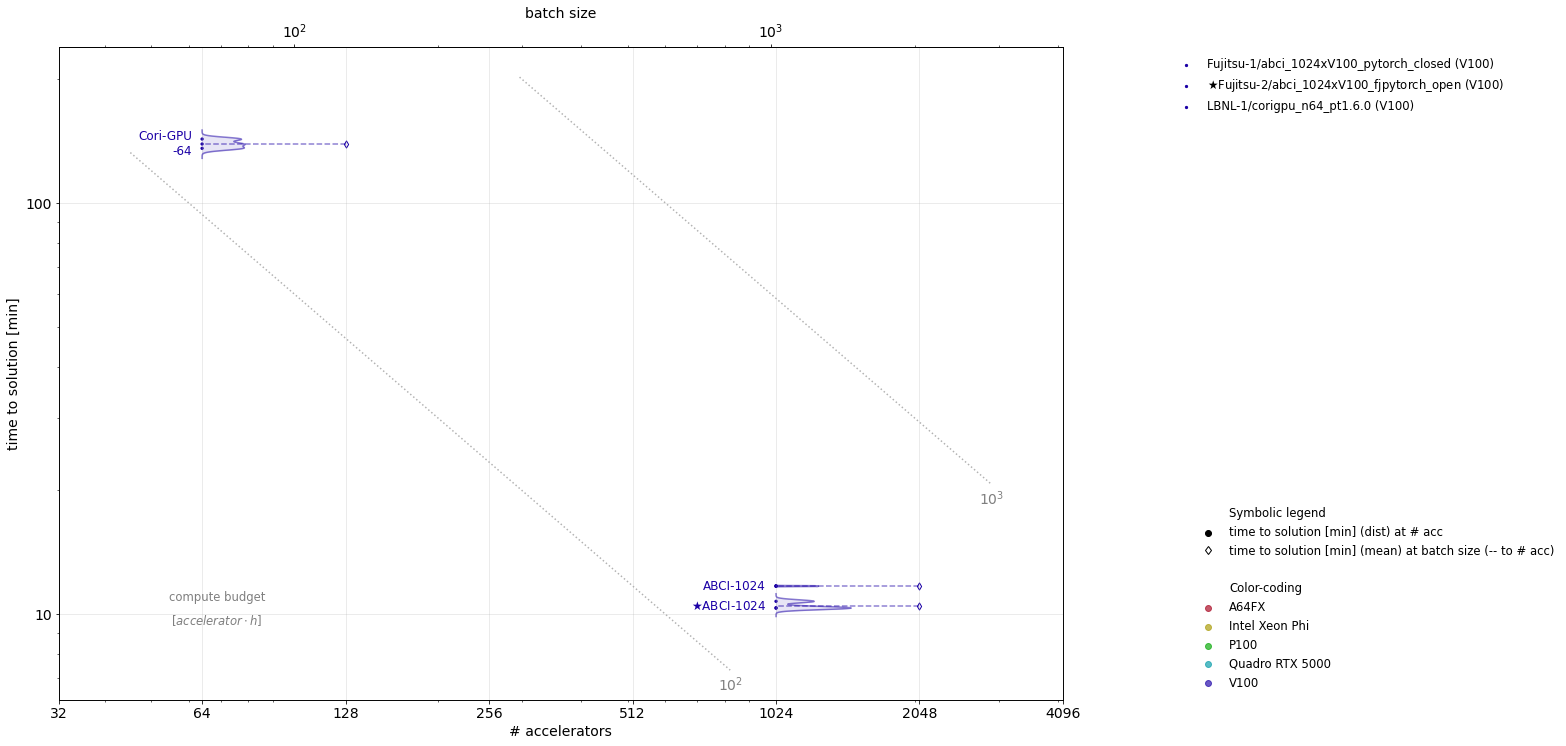

In [50]:
generate_time_to_solution_plot()
# plt.savefig(f'output/{benchmark.name}-time-to-solution.png')

## Relative time analysis: data staging, evaluation and training

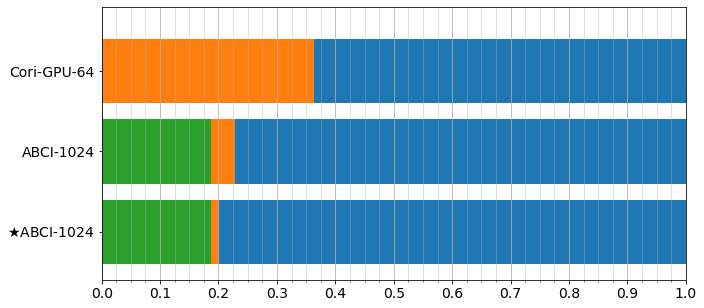

In [51]:
generate_relative_staging_eval_training_times_plot()
# plt.savefig('output/results-relative-staging-eval-training-times.png', dpi=300)

## Compute time analysis: Parameter choice (batch size, # compute units), epoch- and throughput scaling, compute time

Note: different number of training samples used in different submissions! Using median of [121216 121266]


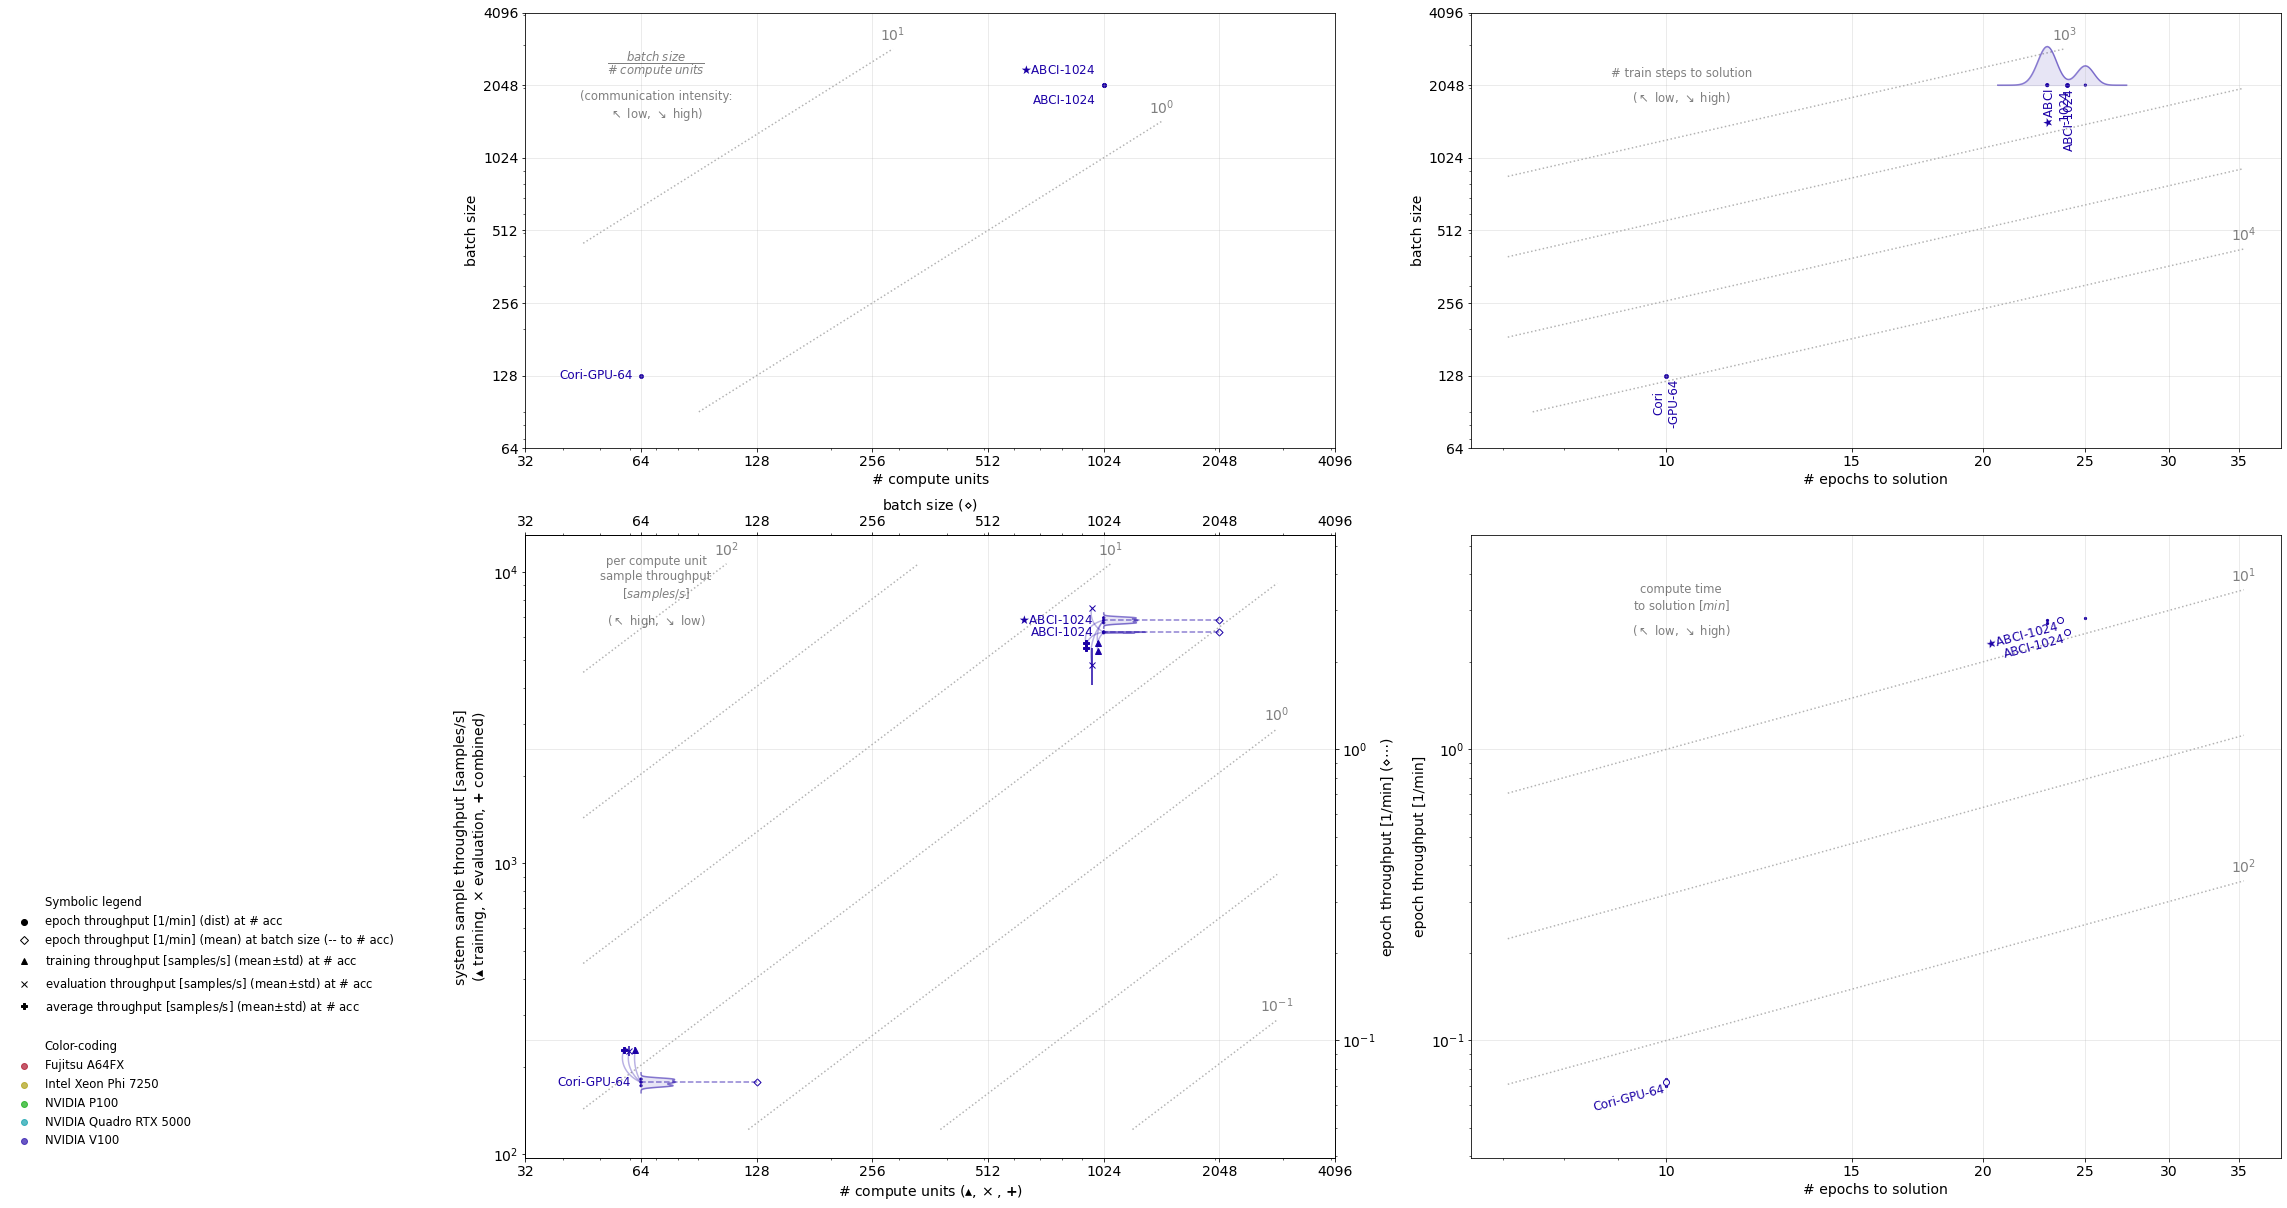

In [52]:
generate_compute_time_analysis_plot()
# plt.savefig(f'output/{benchmark.name}-2x2-compute-analysis-batch-size-acc-epochs-throughput-efficiency-vertical.png', dpi=300)

## Explaining run-to-run variance in terms of # epochs vs. system throughput (logarithmic PCA)

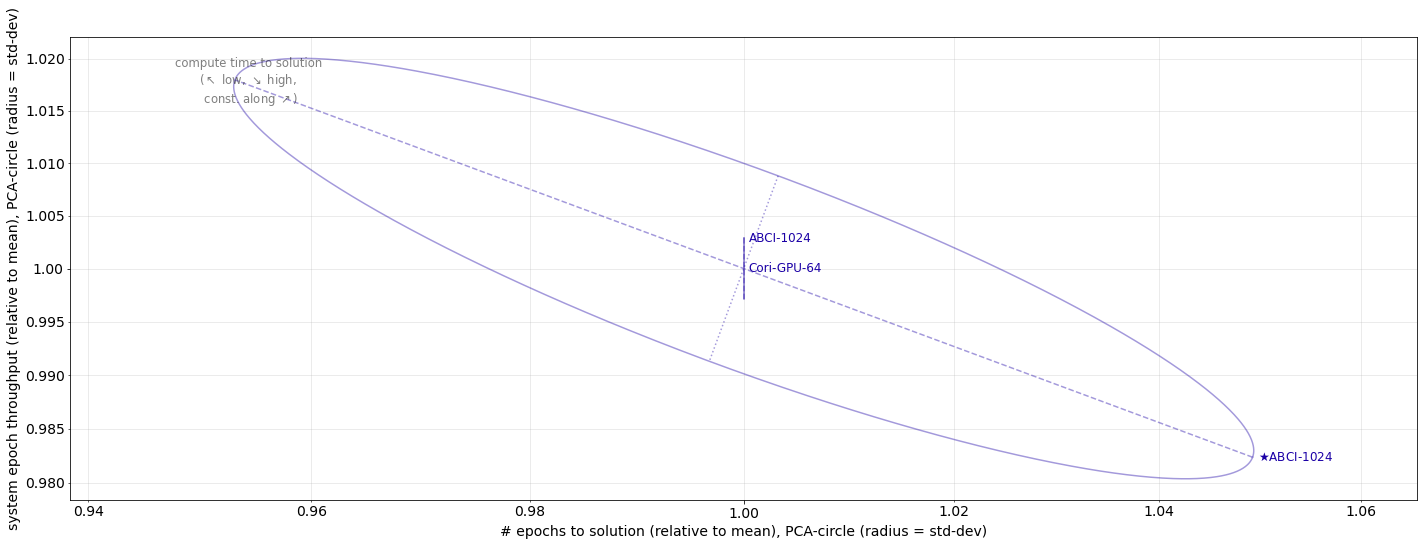

In [53]:
# half-axis correspond to sqrt(variance) of principal components (dashed line first component, dotted line second component)
generate_run_to_run_variation_log_pca_plot()
# plt.savefig('output/{benchmark.name}-run-to-run-variation-log-pca-epochs-throughput.png', dpi=300)